In [1]:
#LSTM Auto Encoder model
#This notebook compare different models and create F1, precision, recall and AUC metrics

In [2]:
!hdfs dfs -ls  /user/fwaseem/videoanomaly/models/

Found 4 items
-rw-------   3 fwaseem users  533519896 2021-05-24 16:31 /user/fwaseem/videoanomaly/models/10F-100E-F1_vae_0.hdf5
-rw-------   3 fwaseem users   23640056 2021-05-29 21:11 /user/fwaseem/videoanomaly/models/anomaly-model_May28.hdf5
-rw-------   3 fwaseem users   23639784 2021-05-12 17:12 /user/fwaseem/videoanomaly/models/anomaly-model_v1.hdf5
-rw-------   3 fwaseem users  141595856 2021-05-23 23:08 /user/fwaseem/videoanomaly/models/anomaly-vae_model_0.hdf5


In [8]:
import os
import subprocess
classpath = os.environ['CLASSPATH']
hadoop_path = os.path.join(os.environ['HADOOP_PREFIX'], 'bin', 'hadoop')
hadoop_classpath = subprocess.check_output([hadoop_path, 'classpath', '--glob']).decode()
os.environ['CLASSPATH']=classpath + os.pathsep + hadoop_classpath

def getGpuDevices(max_number_of_gpus):
    """Finds available GPUs up to max_number_of_gpus"""
    num_gpus=0
    nodes = subprocess.check_output(["nvidia-smi", "--format=csv,noheader,nounits", "--query-gpu=memory.total,memory.free"]).decode()
    gpu_info_arr = [x for x in nodes.split('\n') if len(x) > 0]
    cuda_visible_devices=[]

    for cuda_visible_device, memory in enumerate(gpu_info_arr):
        total_mem, free_mem = memory.split(',')

        total_mem = total_mem.strip()
        free_mem = free_mem.strip()

        if (total_mem == free_mem):
            cuda_visible_devices.append(cuda_visible_device)
            num_gpus=num_gpus+1
            if (num_gpus>=max_number_of_gpus):
                break

    return cuda_visible_devices

In [9]:
print("faraz waseem 36")

faraz waseem 36


In [10]:
import tensorflow as tf
#import tensorflow_hub as hub
import numpy as np
import os
import re
import pandas as pd
import sys

In [11]:
import site
site.addsitedir("./tmp")
from PIL import Image

In [12]:
# Try to allocate 2 GPUs
# Note: if you want to allocate more, make sure to also increase the driver memory accordingly (27GB x num_gpus in Jet Blue, 160GB x num_gpus in Kessel/Polaris)
gpu_list = getGpuDevices(2)

# Set available GPUs for TensorFlow
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(map(str, gpu_list))
print("Reserved GPUs: {}".format(os.environ['CUDA_VISIBLE_DEVICES']))
print(len(gpu_list))

Reserved GPUs: 0,1
2


In [13]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [14]:
# Check that this is GPU instead of CPU version of TensorFlow
assert(tf.test.is_gpu_available() == True)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [15]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [16]:
!hdfs dfs -copyToLocal /user/fwaseem/UCSD_Anomaly_Dataset.tar.gz /tmp/

In [17]:
!gunzip /tmp/UCSD_Anomaly_Dataset.tar.gz
!tar xvf /tmp/UCSD_Anomaly_Dataset.tar

UCSD_Anomaly_Dataset.v1p2/
UCSD_Anomaly_Dataset.v1p2/UCSDped1/
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/139.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/051.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/166.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/136.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/178.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/043.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/167.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/004.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/171.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/157.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/119.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/141.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/113.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/162.tif
UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032/175.tif
UCSD_An

In [18]:
# Try to allocate 2 GPUs
# Note: if you want to allocate more, make sure to also increase the driver memory accordingly (27GB x num_gpus in Jet Blue, 160GB x num_gpus in Kessel/Polaris)
gpu_list = getGpuDevices(2)

# Set available GPUs for TensorFlow
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(map(str, gpu_list))
print("Reserved GPUs: {}".format(os.environ['CUDA_VISIBLE_DEVICES']))
print(len(gpu_list))

Reserved GPUs: 2,3
2


In [19]:
# Check that this is GPU instead of CPU version of TensorFlow
assert(tf.test.is_gpu_available() == True)

In [20]:
BASE = "UCSD_Anomaly_Dataset.v1p2/UCSDped1/"

In [21]:
#https://towardsdatascience.com/prototyping-an-anomaly-detection-system-for-videos-step-by-step-using-lstm-convolutional-4e06b7dcdd29
# Our LSTM auto encoder is based on above article (with tensorflow version changes) and code samples but we will make architecture changes
#http://www.svcl.ucsd.edu/projects/anomaly/dataset.html
class Config:
  DATASET_PATH =BASE + "Train"
  BATCH_SIZE = 4
  EPOCHS = 10
  MODEL_PATH = "anomaly-model.hdf5"

In [22]:
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image

def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the lstm sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips

def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        directory_path = join(Config.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:] == "tif":
                    img = Image.open(img_path).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips

In [23]:
def get_single_test(test_path):
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(test_path)):
        if str(join(test_path, f))[-3:] == "tif":
            img = Image.open(join(test_path, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [24]:
#https://towardsdatascience.com/prototyping-an-anomaly-detection-system-for-videos-step-by-step-using-lstm-convolutional-4e06b7dcdd29
# Our LSTM auto encoder is based on above article (with tensorflow version changes) and code samples but we will make architecture changes
#http://www.svcl.ucsd.edu/projects/anomaly/dataset.html
#assume there is no amomaly during init
class Metrics():
  TP=0
  TN=0
  FP=0
  FN=0

In [25]:
def computeMetrics(sr,groundTruth, normality_score=0.75 ):
    metrics =  Metrics()
    for index in range(len(sr)):
      if (index >= groundTruth.start1 and index <=   groundTruth.end1) or (index >= groundTruth.start2 and index <=   groundTruth.end2): 
         if sr[index] <= normality_score: #true positive    
            metrics.TP = metrics.TP +1
         else:
            metrics.FN = metrics.FN +1       
      else:
         if sr[index] <= normality_score: #true positive    
            metrics.FP = metrics.FP +1
         else:
            metrics.TN = metrics.TN +1 
    return metrics
    

In [26]:
import matplotlib.pyplot as plt

def evaluate(model, test_path,  groundTruth, normality_score=0.75):
    print("got model")
    test = get_single_test(test_path)
    print("got test")
    sz = test.shape[0] - 10
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    #np.save(fileName, sr) 
    # plot the regularity scores
    metrics = computeMetrics(sr, groundTruth, normality_score)
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()
    return metrics

In [27]:
import matplotlib.pyplot as plt

In [28]:
!hdfs dfs -ls /user/fwaseem/videoanomaly/models/

Found 5 items
-rw-------   3 fwaseem users  533519896 2021-05-24 16:31 /user/fwaseem/videoanomaly/models/10F-100E-F1_vae_0.hdf5
-rw-------   3 fwaseem users   23640056 2021-05-29 21:11 /user/fwaseem/videoanomaly/models/anomaly-model_May28.hdf5
-rw-------   3 fwaseem users   23639784 2021-05-12 17:12 /user/fwaseem/videoanomaly/models/anomaly-model_v1.hdf5
-rw-------   3 fwaseem users  141595856 2021-05-23 23:08 /user/fwaseem/videoanomaly/models/anomaly-vae_model_0.hdf5
drwx------   - fwaseem users          0 2021-06-01 00:44 /user/fwaseem/videoanomaly/models/may-31-vae-1


In [29]:
!hdfs dfs -copyToLocal  /user/fwaseem/videoanomaly/models/anomaly-model_May28.hdf5  anomaly-model_May28.hdf5

In [30]:
!pip install --target=./tmp tensorflow-probability

Looking in indexes: https://edge.dist.yahoo.com:4443/artifactory/api/pypi/pypi/simple, https://edge.dist.yahoo.com:4443/pypimirror/simple
     |████████████████████████████████| 4.8 MB 25.7 MB/s eta 0:00:01              | 1.6 MB 25.7 MB/s eta 0:00:01
     |████████████████████████████████| 115 kB 35.7 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 27.3 MB/s eta 0:00:01       | 2.1 MB 27.3 MB/s eta 0:00:01�███████████                | 7.4 MB 27.3 MB/s eta 0:00:01��████▉       | 11.5 MB 27.3 MB/s eta 0:00:01
ERROR: tensorflow-data-validation 0.21.5 has requirement scikit-learn<0.22,>=0.18, but you'll have scikit-learn 0.22.2.post1 which is incompatible.
ERROR: auto-sklearn 0.6.0 has requirement scikit-learn<0.22,>=0.21.0, but you'll have scikit-learn 0.22.2.post1 which is incompatible.
ERROR: apache-beam 2.17.0 has requirement httplib2<=0.12.0,>=0.8, but you'll have httplib2 0.17.0 which is incompatible.
ERROR: apache-beam 2.17.0 has requirement pyarrow<0.16.0,>=0.15.1;

In [31]:
from tensorflow.keras.models import load_model

In [32]:
!ls .

anomaly-model_May28.hdf5  oci-layer13  oci-layer25  oci-layer9
container_tokens	  oci-layer14  oci-layer26  private_etc_passwd
hive-site.xml		  oci-layer15  oci-layer27  private_slash_tmp
jup3.zip		  oci-layer16  oci-layer28  private_var_slash_tmp
kernel-271.json		  oci-layer17  oci-layer29  py4j-0.10.9-src.zip
kernel.py		  oci-layer18  oci-layer3   pyspark.zip
launch_container.sh	  oci-layer19  oci-layer30  __spark_conf__
oci-config32		  oci-layer2   oci-layer31  __spark_libs__
oci-layer0		  oci-layer20  oci-layer4   tmp
oci-layer1		  oci-layer21  oci-layer5   UCSD_Anomaly_Dataset.v1p2
oci-layer10		  oci-layer22  oci-layer6
oci-layer11		  oci-layer23  oci-layer7
oci-layer12		  oci-layer24  oci-layer8


In [33]:
loaded_model = load_model('anomaly-model_May28.hdf5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [34]:
!ls UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/

Test001     Test007  Test014_gt  Test020     Test024_gt  Test032
Test002     Test008  Test015	 Test021     Test025	 Test032_gt
Test003     Test009  Test016	 Test021_gt  Test026	 Test033
Test003_gt  Test010  Test017	 Test022     Test027	 Test034
Test004     Test011  Test018	 Test022_gt  Test028	 Test035
Test004_gt  Test012  Test018_gt  Test023     Test029	 Test036
Test005     Test013  Test019	 Test023_gt  Test030	 UCSDped1.m
Test006     Test014  Test019_gt  Test024     Test031	 UCSDped1.m~


In [51]:
#now load ground truth
groundTruth = open("UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/UCSDped1.m", "r")


In [52]:
framesTruth = groundTruth.read()

In [53]:
framesTruth = framesTruth.replace("TestVideoFile","");
framesTruth = framesTruth.replace("{end+1}.gt_frame","");
framesTruth = framesTruth.replace("=","");
framesTruth = framesTruth.replace("{}","");
framesTruth = framesTruth.replace(";","");
framesTruth = framesTruth.replace("'","");

In [54]:
framesTruth = framesTruth.split("\n")

In [55]:
class GroundTruth:
  start1=-1
  end1 = -1
  start2=-1
  end2 = -1
    

In [56]:
#adjust indexes as well as indexes are zero based in python
frameTruthList =[]
import re
for frame in framesTruth:
    numbers = re.findall('[0-9]+', frame)
    frame = GroundTruth()
    if (len(numbers) >= 2):
        frame.start1=int(numbers[0])-1
        frame.end1=int(numbers[1])-1
    if (len(numbers) >= 4):
        frame.start2=int(numbers[2])-1
        frame.end2=int(numbers[3])-1
    frameTruthList.append(frame)    

In [57]:
for frame in frameTruthList:
    print(str(frame.start1))

-1
59
49
90
30
4
0
0
0
0
0
69
129
0
0
137
122
0
53
63
44
30
15
7
49
39
76
9
104
0
174
0
0
4
0
85
14
-1


In [58]:
framesTruth[36]

'  [15:108]'

In [59]:
frameTruthList[36].end1

107

In [60]:
print("faraz 22")

faraz 22


got model
got test


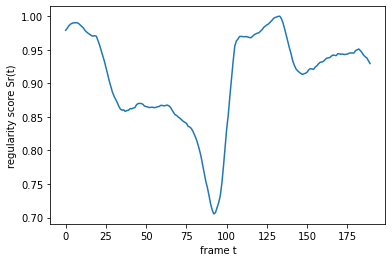

In [61]:
metrics = evaluate(loaded_model, BASE + "/Test/Test036", frameTruthList[36], 0.85)

got model
got test


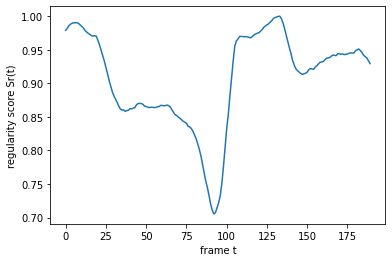

In [62]:
#evaluate(loaded_model, entry.path, frameTruthList[index], 0.85)
metrics = evaluate(loaded_model, "UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test036", frameTruthList[36], 0.85)

In [63]:
metrics.TN

96

In [64]:
#compute F1 scores for above frame 36
epsilon=.000001
def computeF1(metrics):
    precision = metrics.TP / (metrics.TP + metrics.FP + + epsilon)
    recall = metrics.TP / (metrics.TP + metrics.FN + + epsilon)
    FPR = metrics.FP / (metrics.TN + metrics.FP + + epsilon)
    F1 = 2 * (precision * recall)/ (precision + recall + epsilon)
    return precision,recall,F1, FPR
    

In [66]:
#now do it for all 36 frames
def updatemetrics(oldmetrics, metrics ):
    oldmetrics.TP = oldmetrics.TP + metrics.TP
    oldmetrics.FP = oldmetrics.FP + metrics.FP
    oldmetrics.TN = oldmetrics.TN + metrics.TN
    oldmetrics.FN = oldmetrics.FN + metrics.FN
    return oldmetrics


In [67]:
def runTests(regularity_score):
    directory = BASE + "/Test"
    globalMetric = Metrics()
    for entry in os.scandir(directory):
            if not (entry.path.endswith("gt") or entry.path.endswith(".m") or entry.path.endswith(".m~") or entry.path.endswith("017") or entry.path.endswith(".DS_Store")):
                print(entry.path)
                index = int(entry.path[-3:])
                deltametric = evaluate(loaded_model, entry.path, frameTruthList[index], regularity_score)
                globalMetric =  updatemetrics(globalMetric, deltametric)
    return  globalMetric           

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test012
got model
got test


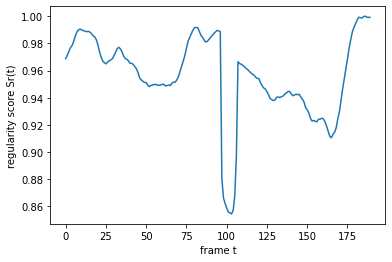

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test020
got model
got test


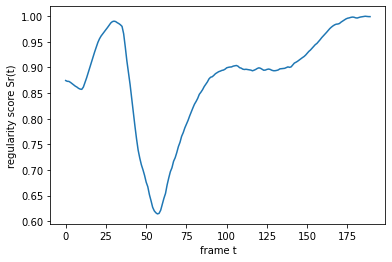

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test024
got model
got test


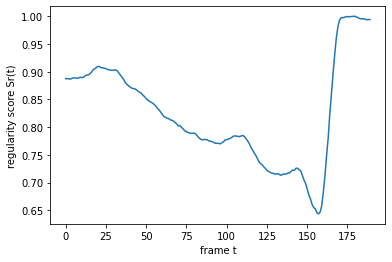

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test005
got model
got test


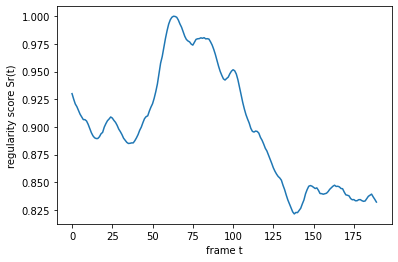

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test025
got model
got test


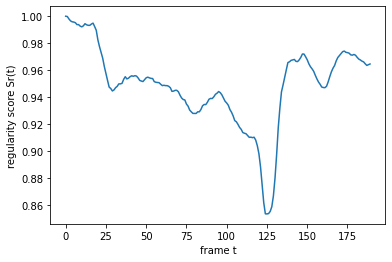

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test016
got model
got test


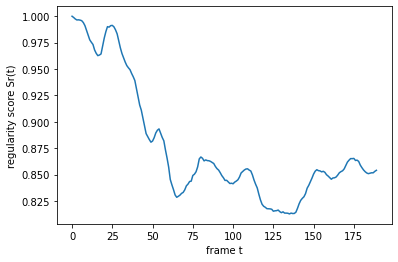

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test023
got model
got test


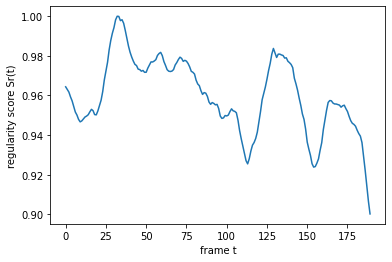

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test032
got model
got test


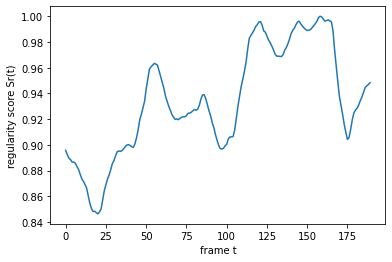

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test031
got model
got test


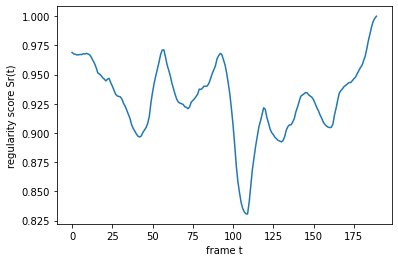

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test015
got model
got test


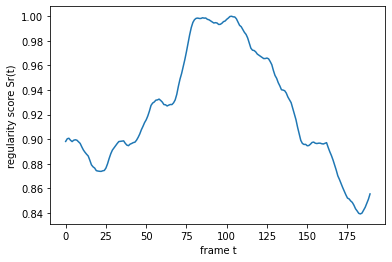

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test022
got model
got test


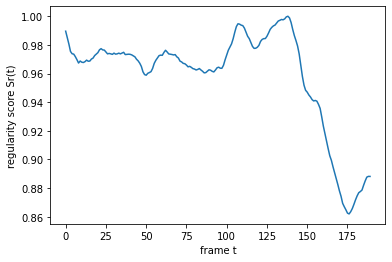

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test029
got model
got test


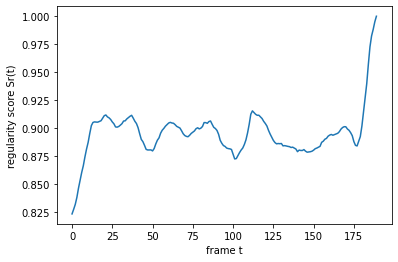

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test030
got model
got test


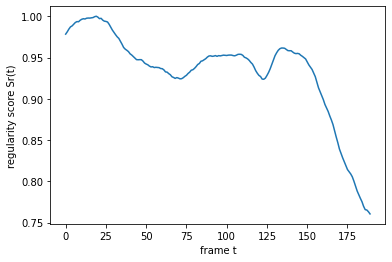

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test004
got model
got test


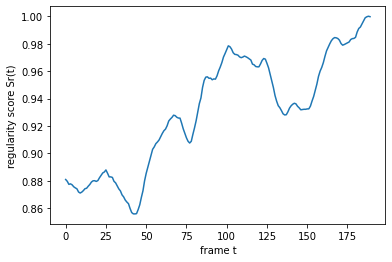

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test034
got model
got test


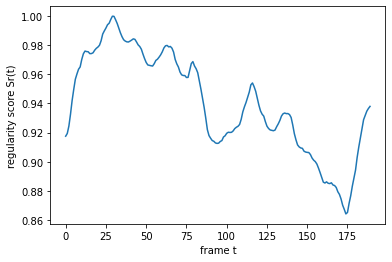

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test009
got model
got test


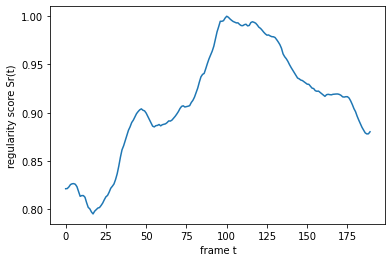

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test011
got model
got test


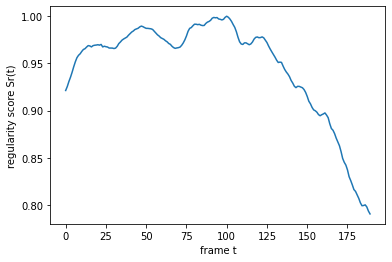

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test018
got model
got test


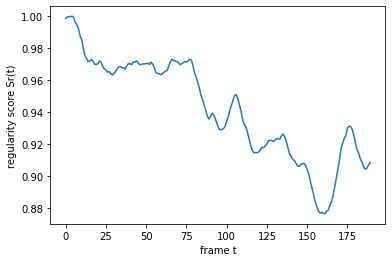

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test002
got model
got test


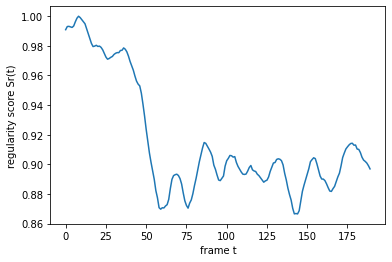

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test008
got model
got test


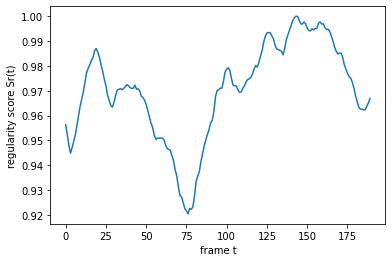

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test007
got model
got test


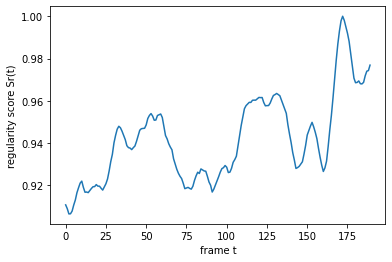

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test033
got model
got test


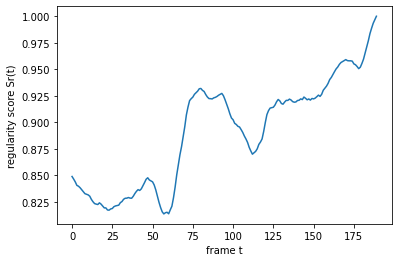

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test036
got model
got test


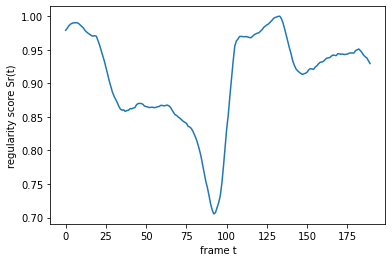

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test014
got model
got test


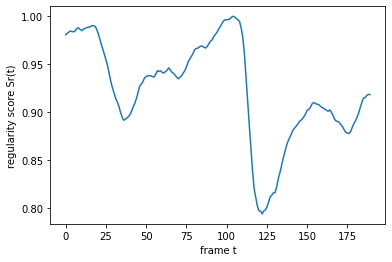

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test021
got model
got test


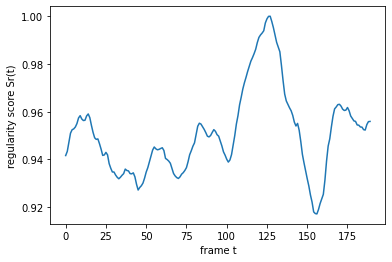

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test003
got model
got test


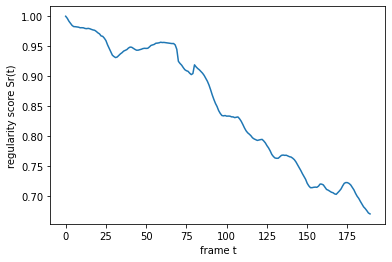

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test001
got model
got test


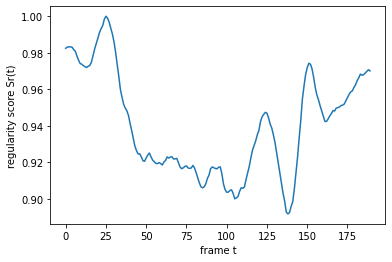

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test013
got model
got test


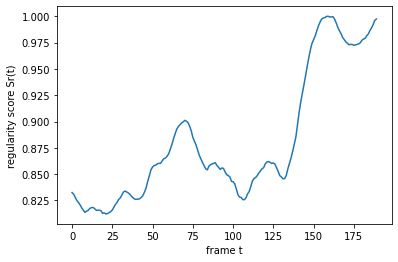

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test027
got model
got test


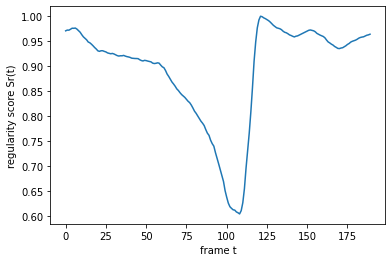

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test010
got model
got test


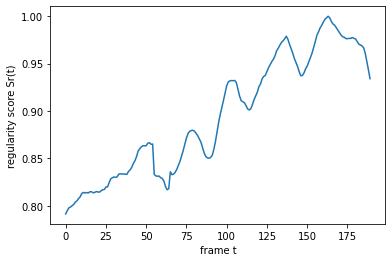

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test028
got model
got test


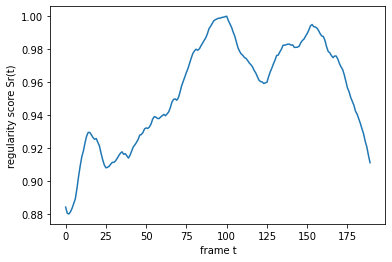

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test026
got model
got test


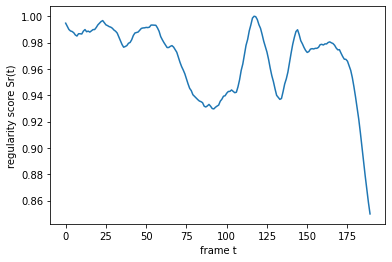

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test019
got model
got test


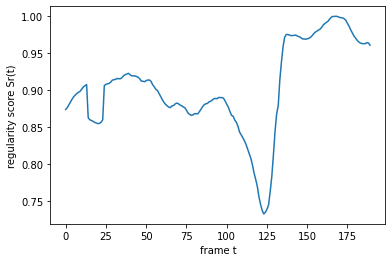

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test035
got model
got test


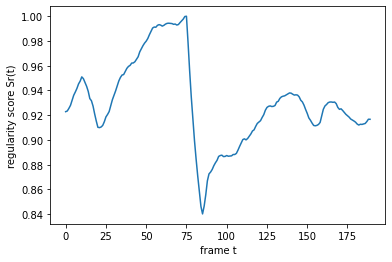

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test006
got model
got test


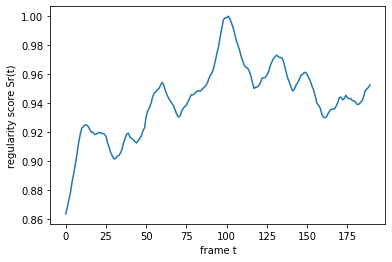

In [71]:
globalMetric = runTests(0.70)
precision,recall,F1, FPR = computeF1(globalMetric)

In [72]:
print("precision " + str(precision))
print("recall " + str(recall))
print("F1 " + str(F1))
print("FPR " + str(FPR))

precision 0.9999999818181822
recall 0.014146090531341027
F1 0.027897512421677578
FPR 0.0


UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test012
got model
got test


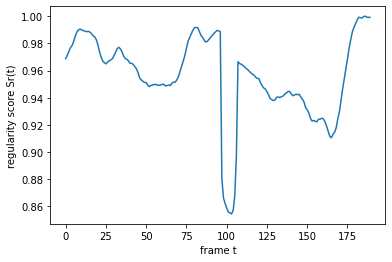

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test020
got model
got test


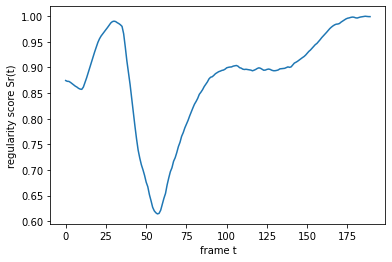

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test024
got model
got test


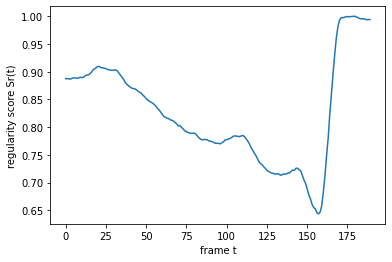

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test005
got model
got test


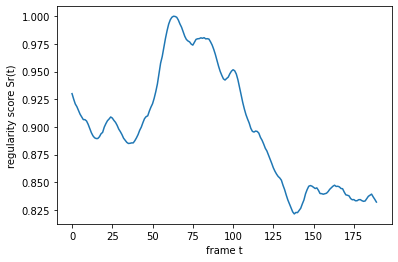

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test025
got model
got test


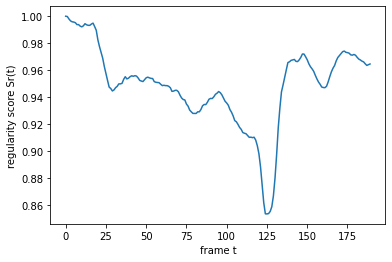

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test016
got model
got test


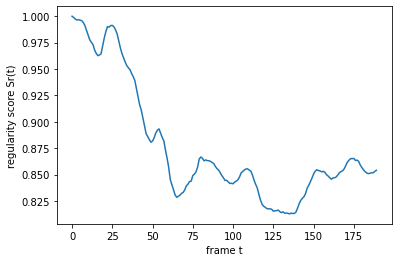

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test023
got model
got test


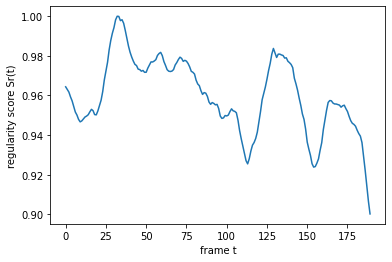

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test032
got model
got test


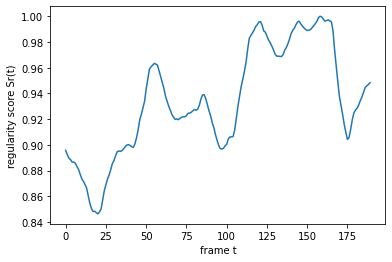

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test031
got model
got test


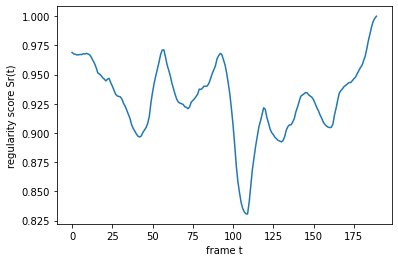

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test015
got model
got test


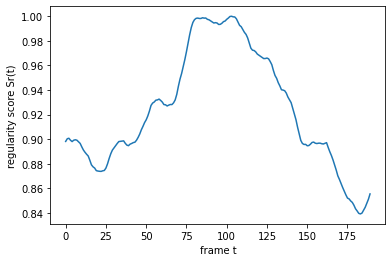

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test022
got model
got test


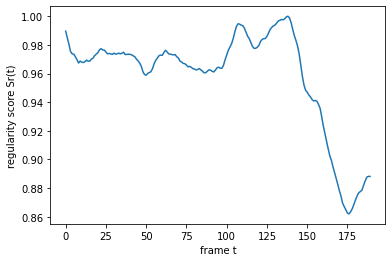

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test029
got model
got test


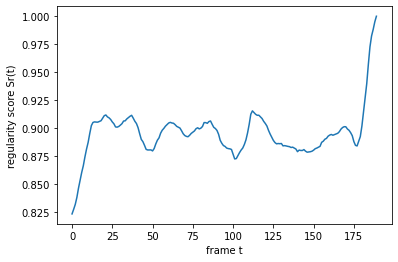

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test030
got model
got test


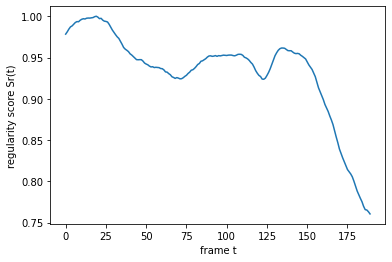

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test004
got model
got test


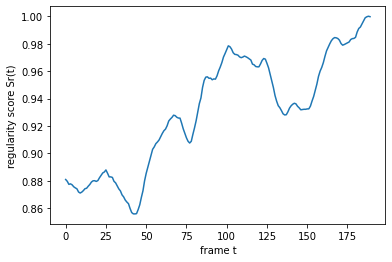

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test034
got model
got test


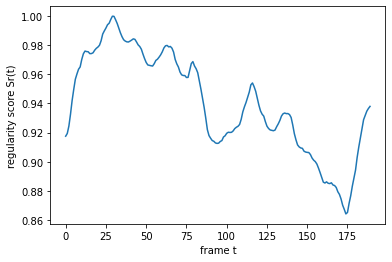

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test009
got model
got test


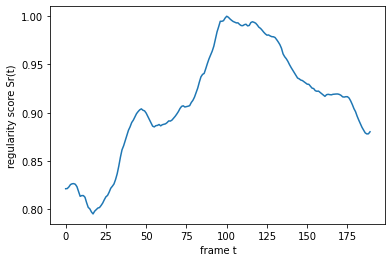

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test011
got model
got test


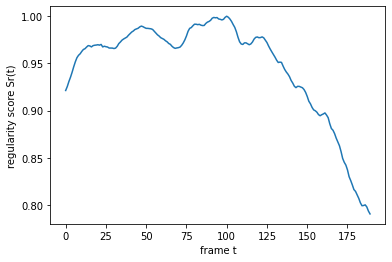

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test018
got model
got test


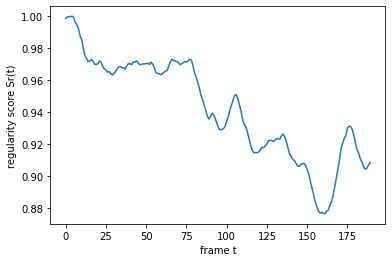

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test002
got model
got test


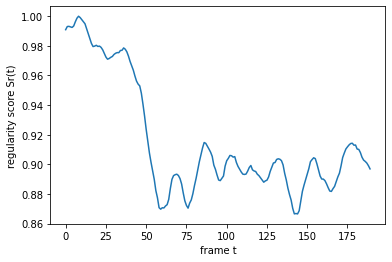

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test008
got model
got test


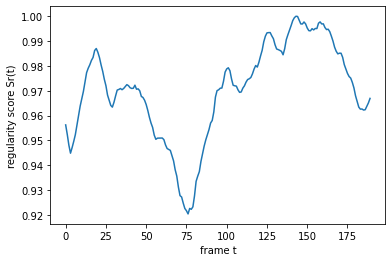

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test007
got model
got test


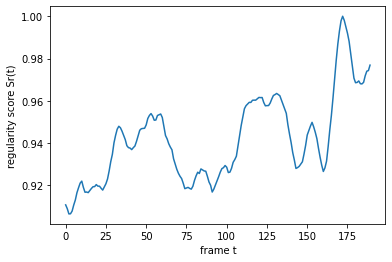

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test033
got model
got test


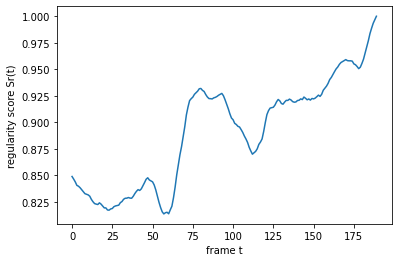

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test036
got model
got test


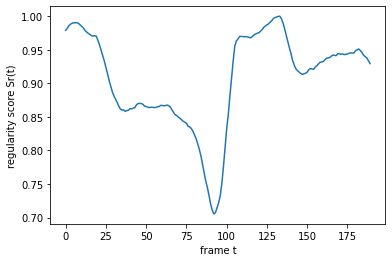

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test014
got model
got test


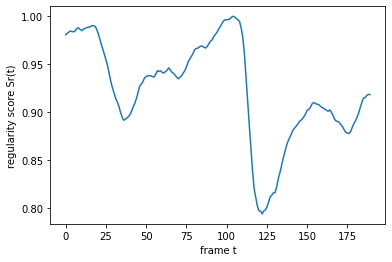

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test021
got model
got test


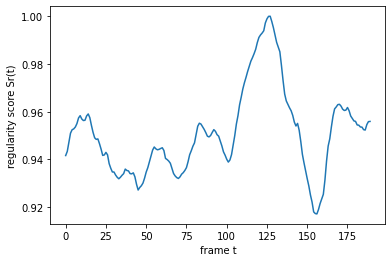

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test003
got model
got test


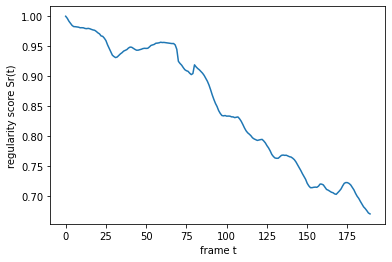

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test001
got model
got test


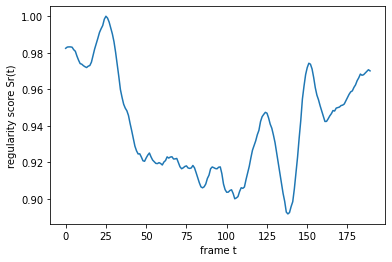

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test013
got model
got test


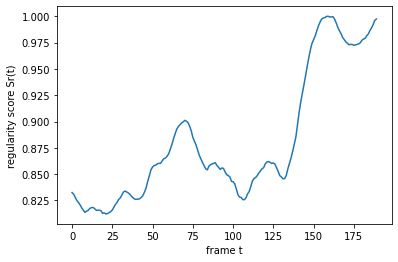

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test027
got model
got test


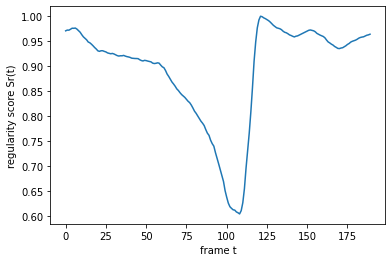

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test010
got model
got test


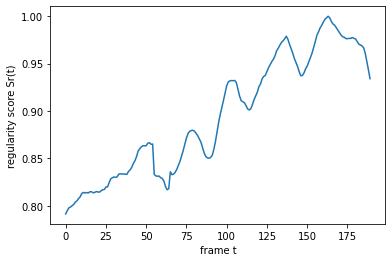

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test028
got model
got test


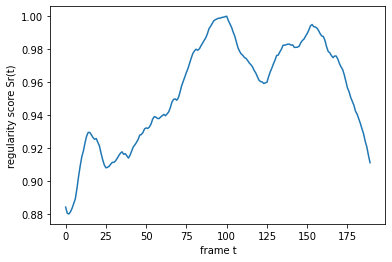

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test026
got model
got test


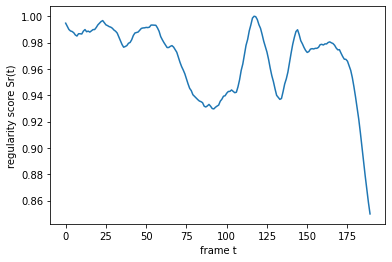

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test019
got model
got test


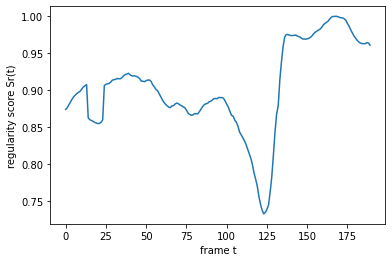

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test035
got model
got test


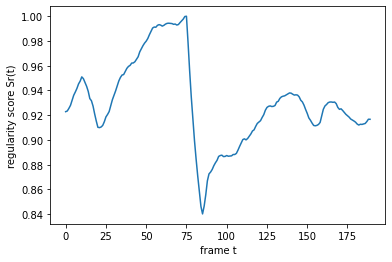

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test006
got model
got test


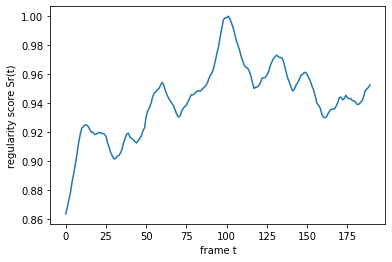

In [73]:
globalMetric = runTests(0.65)
precision,recall,F1, FPR = computeF1(globalMetric)

In [74]:
print("precision " + str(precision))
print("recall " + str(recall))
print("F1 " + str(F1))
print("FPR " + str(FPR))

precision 0.999999956521741
recall 0.005915637858560793
F1 0.011761686076972429
FPR 0.0


UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test012
got model
got test


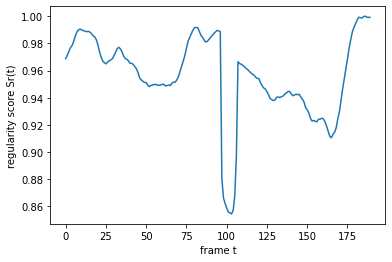

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test020
got model
got test


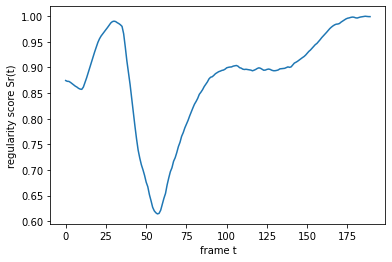

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test024
got model
got test


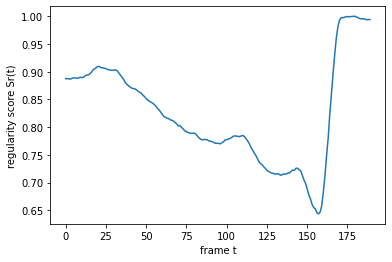

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test005
got model
got test


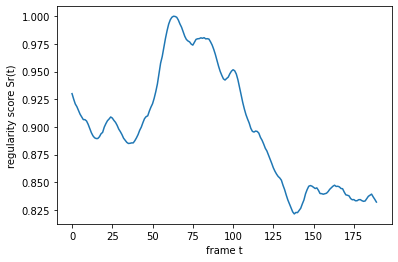

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test025
got model
got test


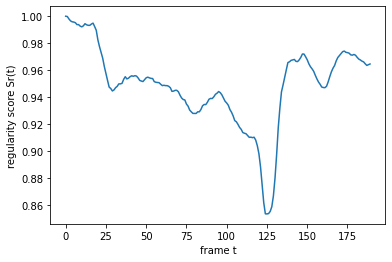

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test016
got model
got test


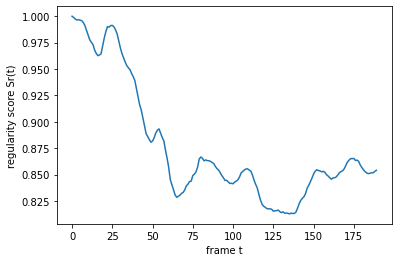

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test023
got model
got test


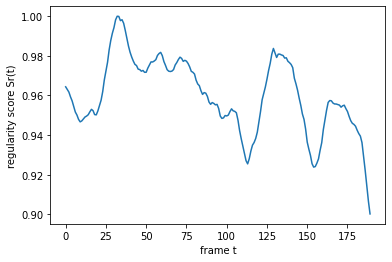

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test032
got model
got test


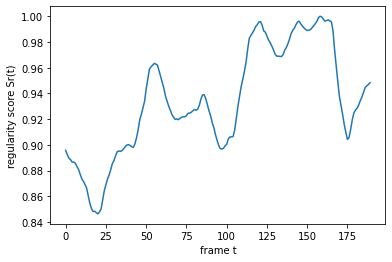

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test031
got model
got test


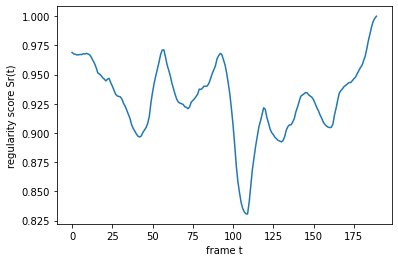

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test015
got model
got test


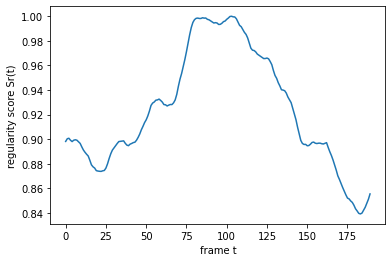

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test022
got model
got test


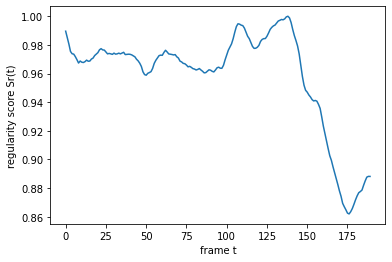

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test029
got model
got test


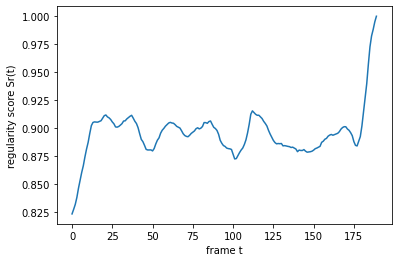

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test030
got model
got test


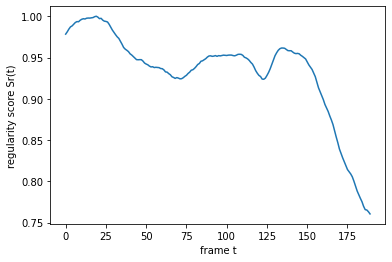

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test004
got model
got test


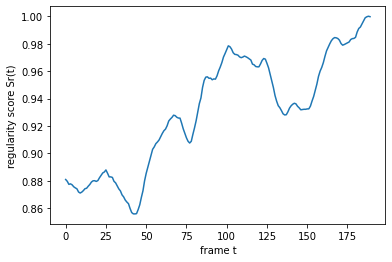

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test034
got model
got test


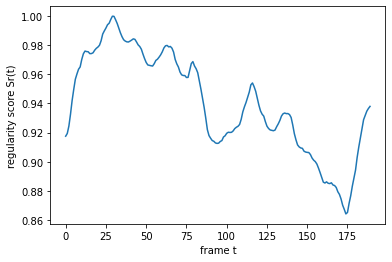

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test009
got model
got test


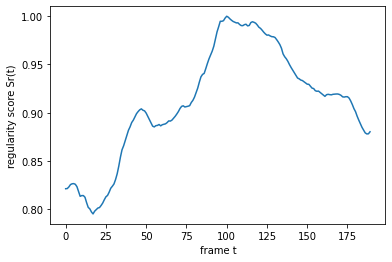

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test011
got model
got test


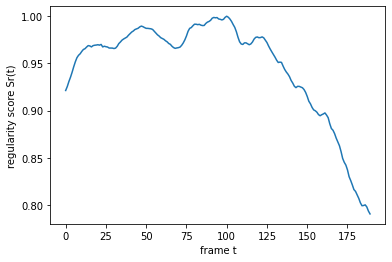

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test018
got model
got test


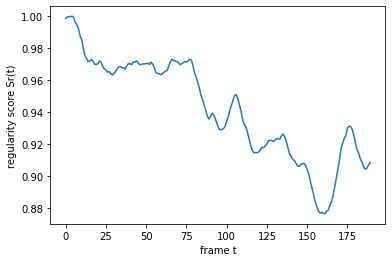

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test002
got model
got test


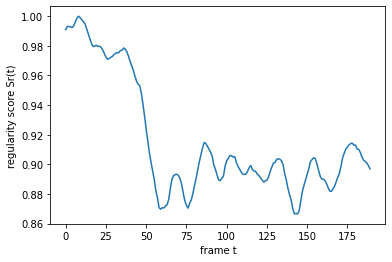

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test008
got model
got test


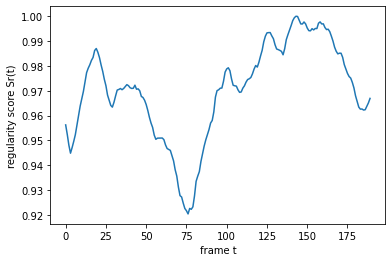

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test007
got model
got test


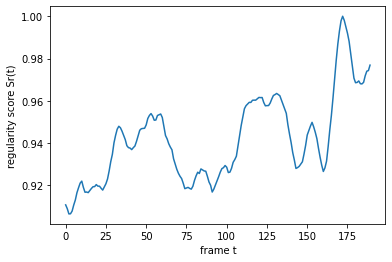

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test033
got model
got test


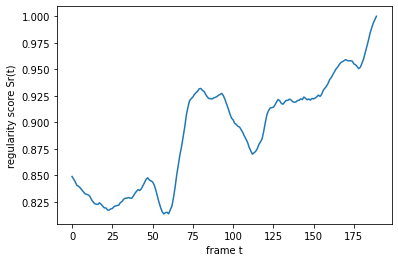

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test036
got model
got test


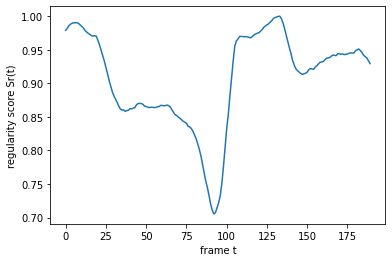

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test014
got model
got test


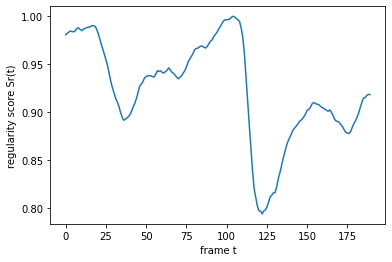

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test021
got model
got test


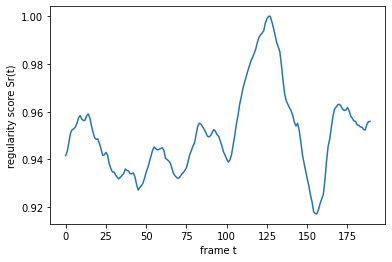

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test003
got model
got test


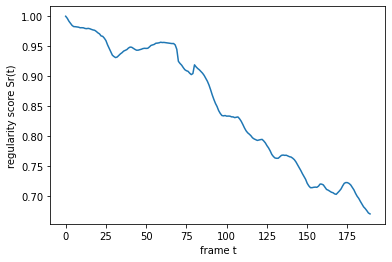

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test001
got model
got test


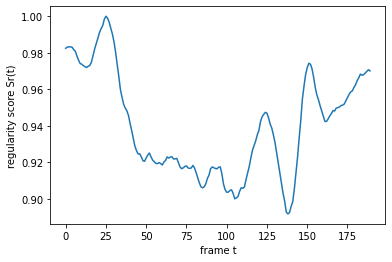

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test013
got model
got test


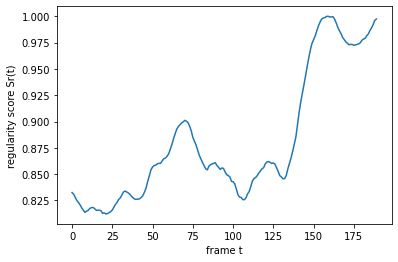

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test027
got model
got test


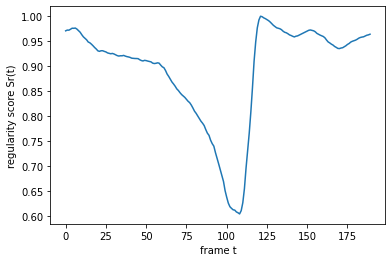

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test010
got model
got test


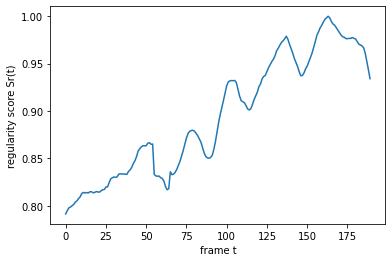

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test028
got model
got test


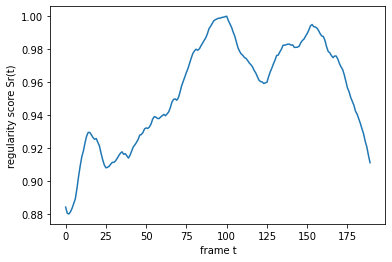

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test026
got model
got test


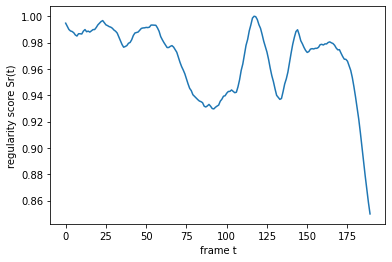

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test019
got model
got test


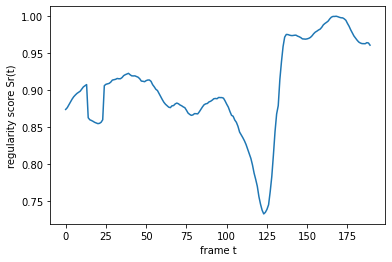

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test035
got model
got test


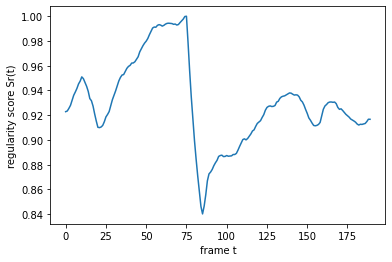

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test006
got model
got test


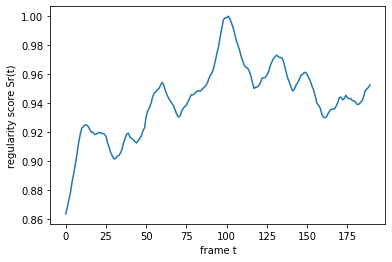

In [116]:
globalMetric = runTests(0.90)
precision,recall,F1, FPR = computeF1(globalMetric)

In [117]:
print(globalMetric.TP)
print(globalMetric.TN)
print(globalMetric.FP)
print(globalMetric.FN)

1448
2275
487
2440


In [120]:
precision,recall,F1, FPR = computeF1(globalMetric)

In [121]:
print("precision " + str(precision))
print("recall(TPR) " + str(recall))
print("F1 " + str(F1))
print("False positive rate " + str(FPR))

precision 0.7483204130499636
recall(TPR) 0.3724279834433056
F1 0.49733769792546695
False positive rate 0.17632150609112185


In [ ]:
#TPR is same as recall
#TPR = (num. of true positive frames/num. of positive frames)
#FPR = (num. of false positive frames/num. of negative frames)


UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test012
got model
got test


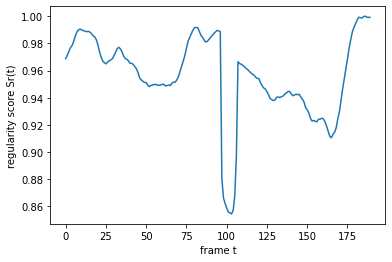

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test020
got model
got test


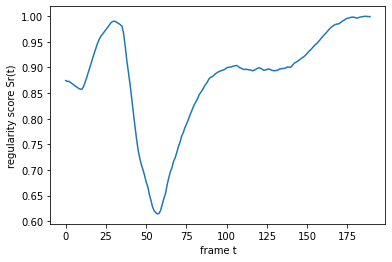

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test024
got model
got test


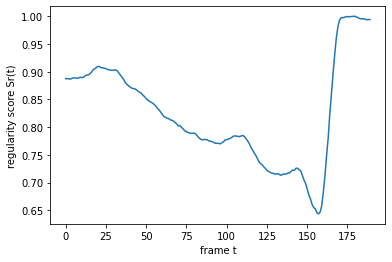

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test005
got model
got test


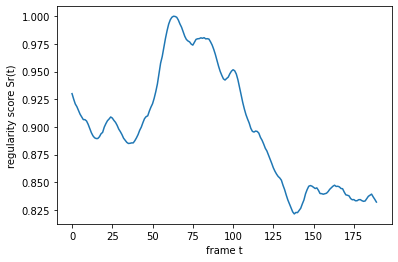

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test025
got model
got test


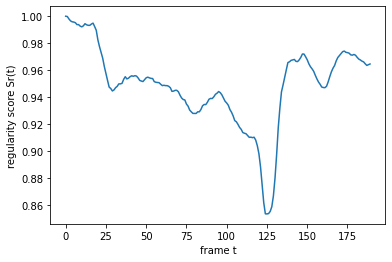

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test016
got model
got test


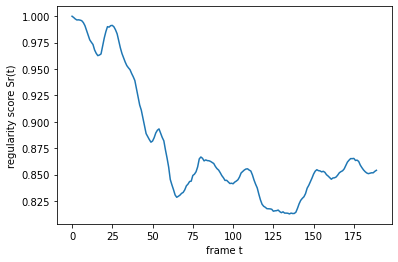

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test023
got model
got test


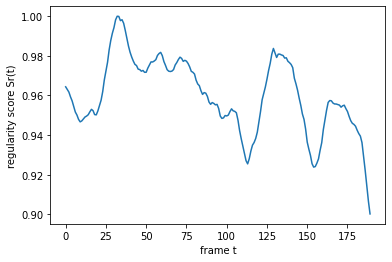

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test032
got model
got test


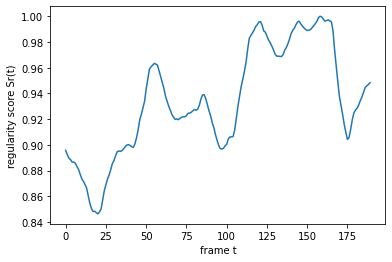

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test031
got model
got test


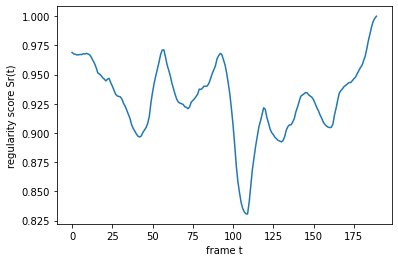

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test015
got model
got test


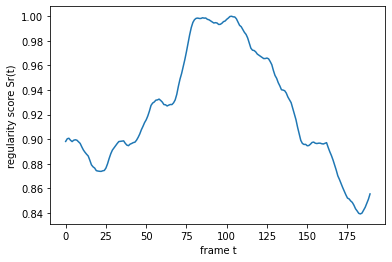

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test022
got model
got test


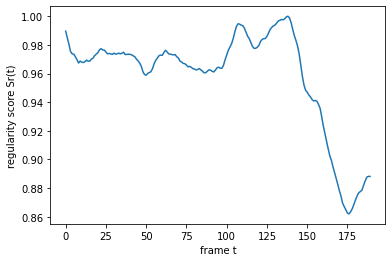

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test029
got model
got test


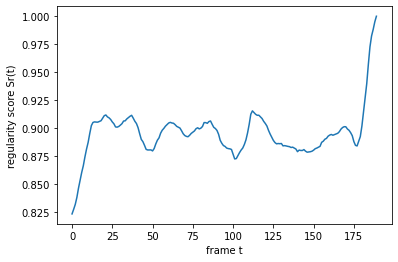

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test030
got model
got test


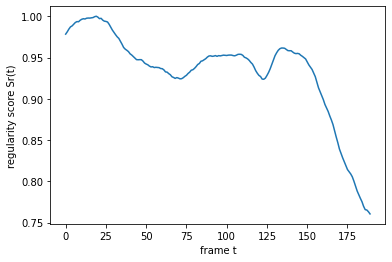

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test004
got model
got test


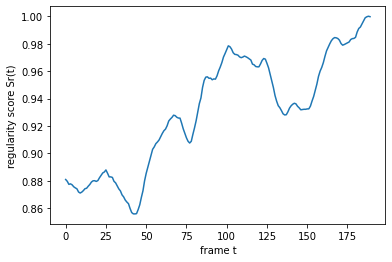

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test034
got model
got test


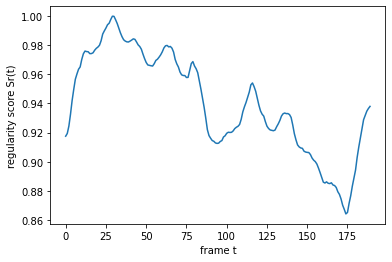

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test009
got model
got test


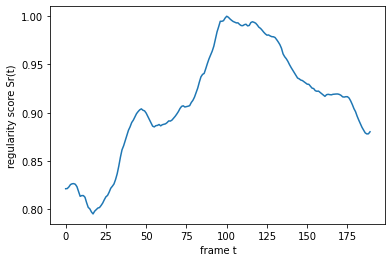

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test011
got model
got test


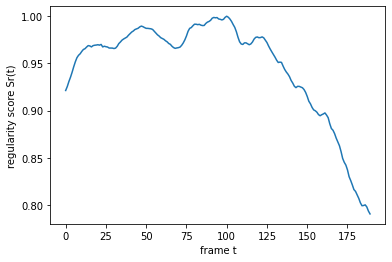

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test018
got model
got test


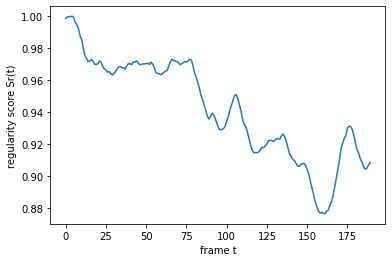

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test002
got model
got test


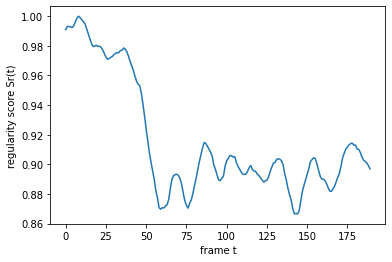

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test008
got model
got test


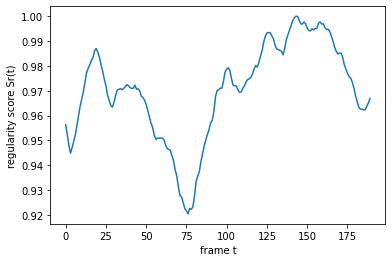

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test007
got model
got test


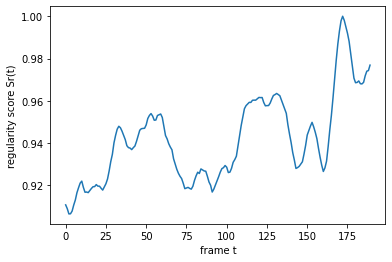

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test033
got model
got test


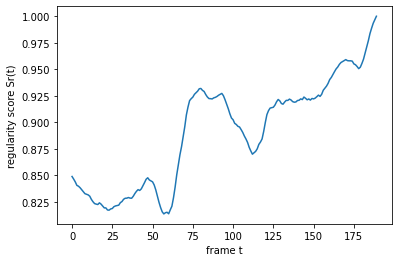

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test036
got model
got test


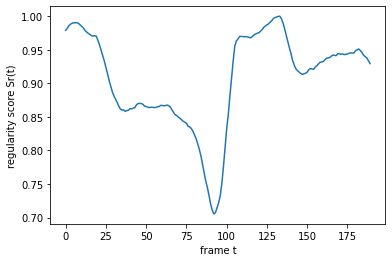

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test014
got model
got test


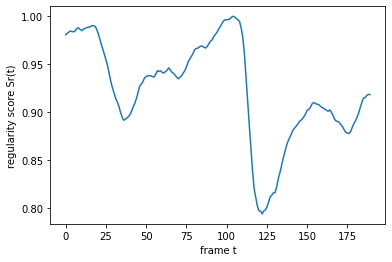

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test021
got model
got test


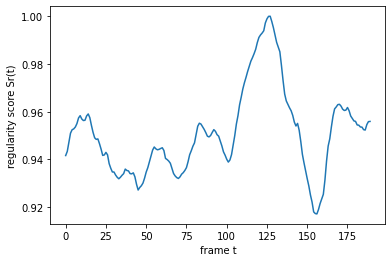

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test003
got model
got test


In [ ]:
globalMetric = runTests(0.95)
precision,recall,F1, FPR = computeF1(globalMetric)

In [123]:
print("precision " + str(precision))
print("recall(TPR) " + str(recall))
print("F1 " + str(F1))
print("False positive rate " + str(FPR))

precision 0.6910509630112043
recall(TPR) 0.7289094648330995
F1 0.7094750290303327
False positive rate 0.4587255610214607


In [124]:
print(globalMetric.TP)
print(globalMetric.TN)
print(globalMetric.FP)
print(globalMetric.FN)

2834
1495
1267
1054


In [125]:
2834+1495+1267+1054

6650

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test012
got model
got test


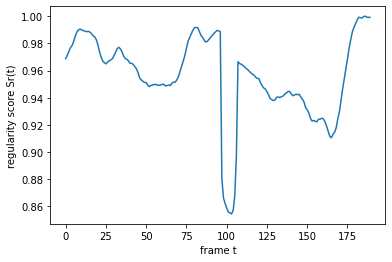

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test020
got model
got test


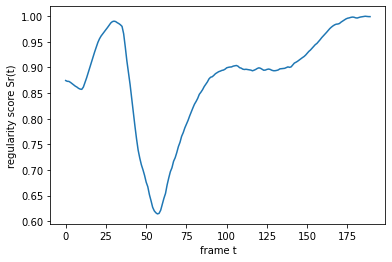

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test024
got model
got test


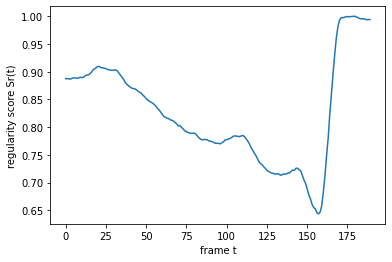

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test005
got model
got test


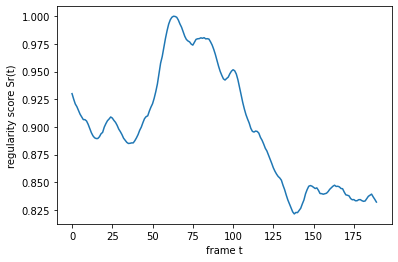

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test025
got model
got test


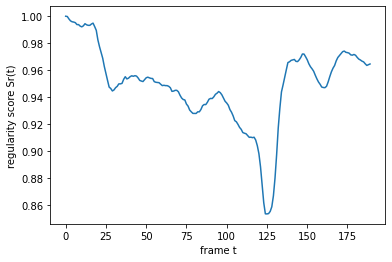

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test016
got model
got test


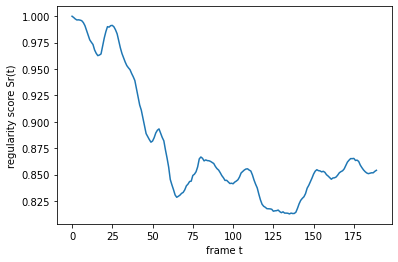

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test023
got model
got test


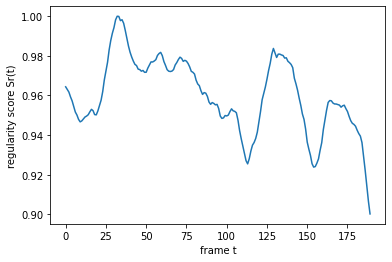

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test032
got model
got test


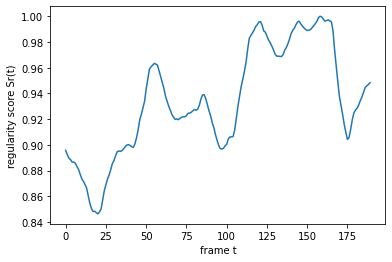

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test031
got model
got test


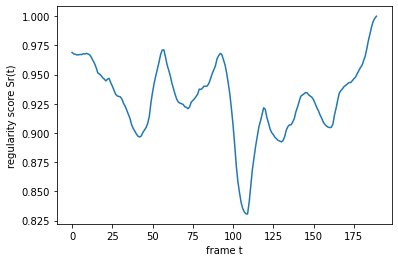

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test015
got model
got test


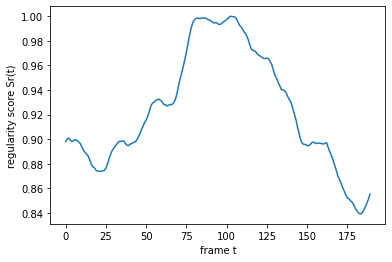

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test022
got model
got test


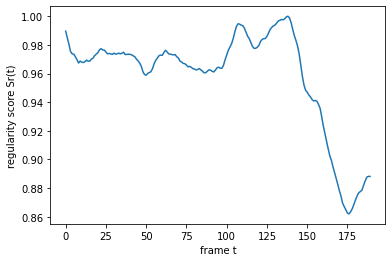

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test029
got model
got test


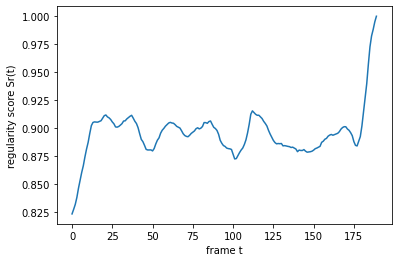

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test030
got model
got test


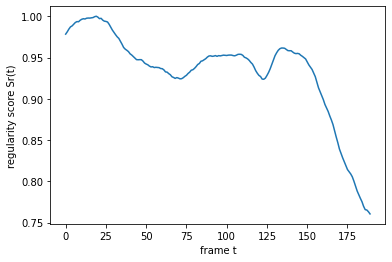

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test004
got model
got test


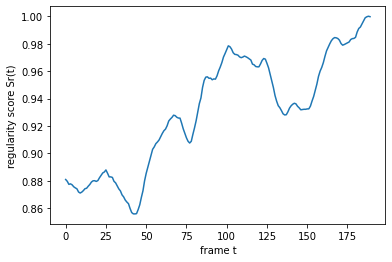

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test034
got model
got test


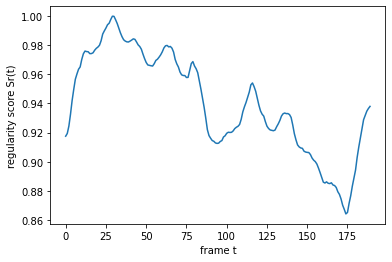

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test009
got model
got test


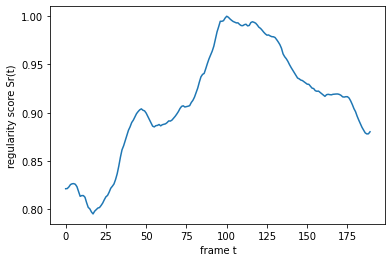

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test011
got model
got test


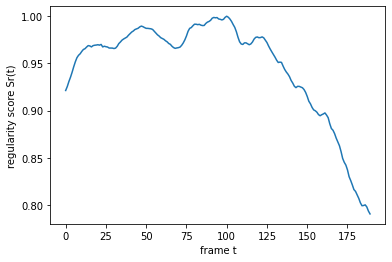

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test018
got model
got test


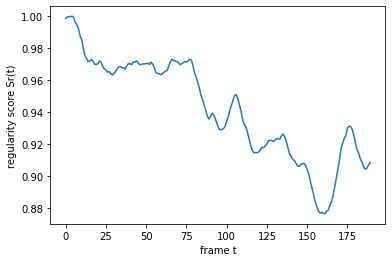

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test002
got model
got test


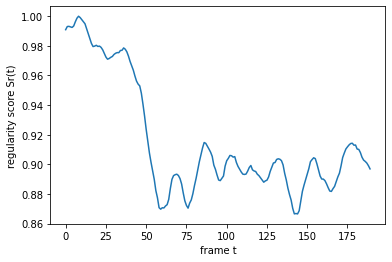

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test008
got model
got test


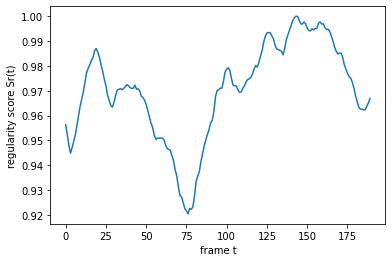

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test007
got model
got test


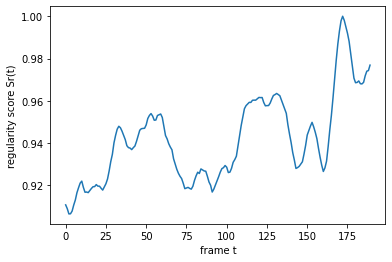

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test033
got model
got test


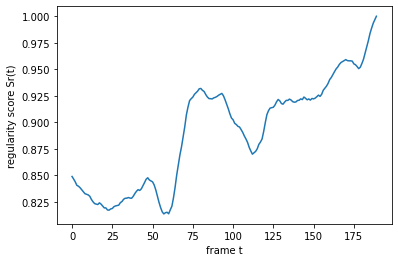

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test036
got model
got test


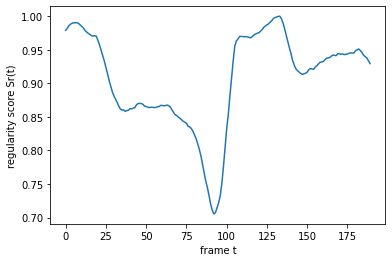

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test014
got model
got test


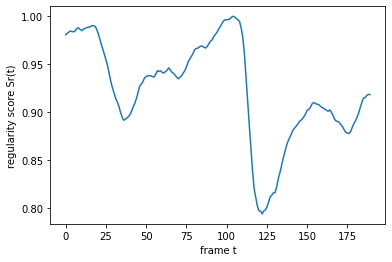

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test021
got model
got test


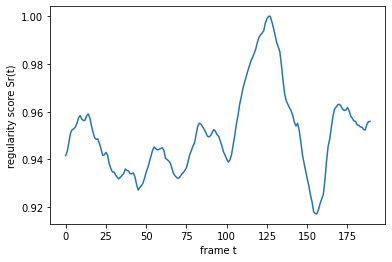

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test003
got model
got test


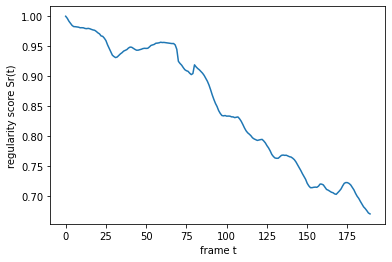

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test001
got model
got test


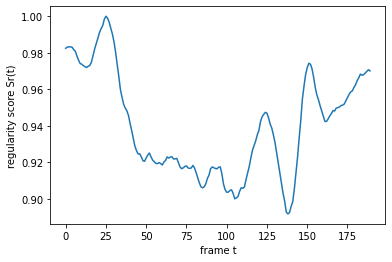

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test013
got model
got test


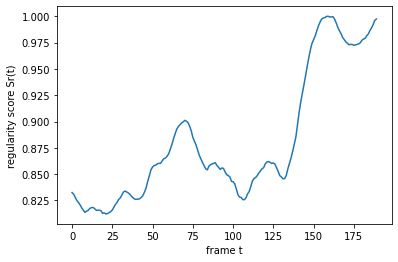

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test027
got model
got test


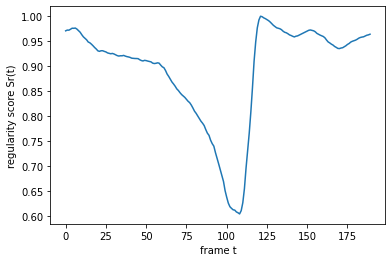

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test010
got model
got test


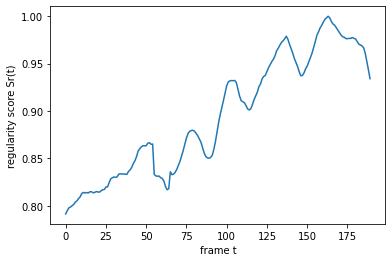

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test028
got model
got test


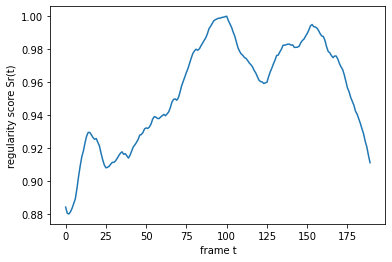

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test026
got model
got test


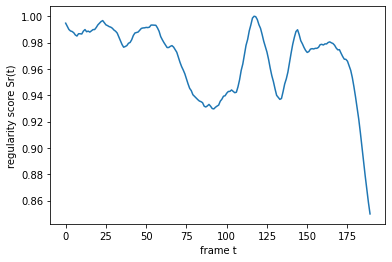

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test019
got model
got test


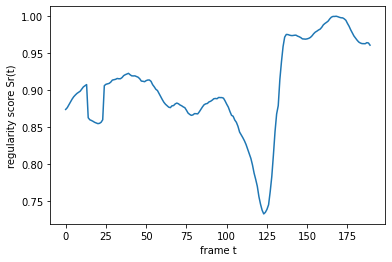

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test035
got model
got test


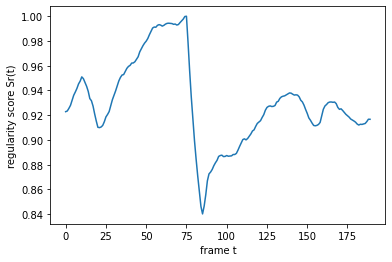

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test006
got model
got test


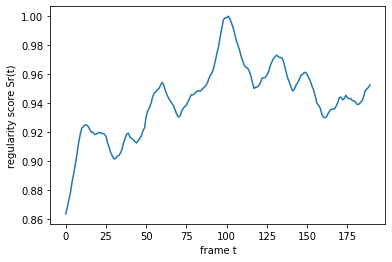

In [126]:
globalMetric = runTests(0.80)
precision,recall,F1, FPR = computeF1(globalMetric)

In [112]:
print(globalMetric.TP)
print(globalMetric.TN)
print(globalMetric.FP)
print(globalMetric.FN)

731
2685
77
3157


In [128]:
print("precision " + str(precision))
print("recall(TPR) " + str(recall))
print("F1 " + str(F1))
print("False positive rate " + str(FPR))

precision 0.9791666632667825
recall(TPR) 0.0725308641788758
F1 0.13505734278125753
False positive rate 0.00217233888407953


UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test012
got model
got test


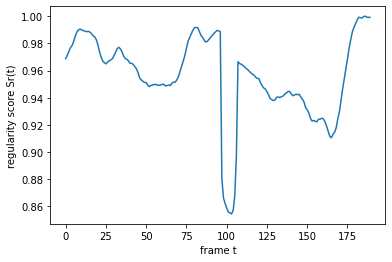

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test020
got model
got test


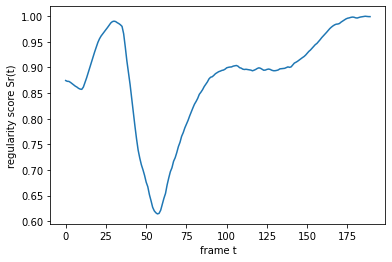

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test024
got model
got test


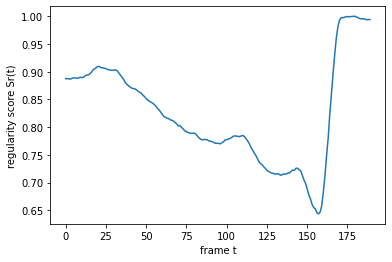

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test005
got model
got test


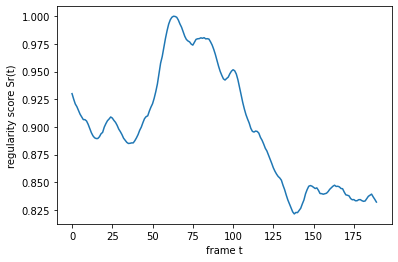

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test025
got model
got test


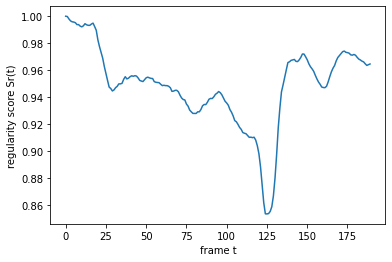

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test016
got model
got test


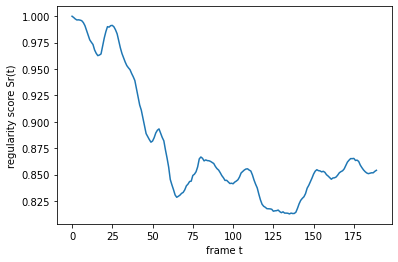

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test023
got model
got test


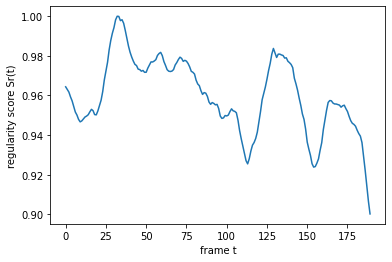

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test032
got model
got test


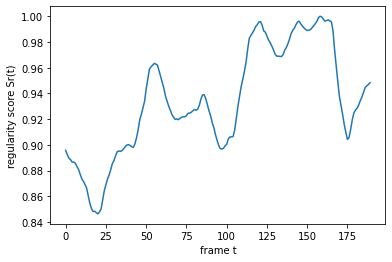

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test031
got model
got test


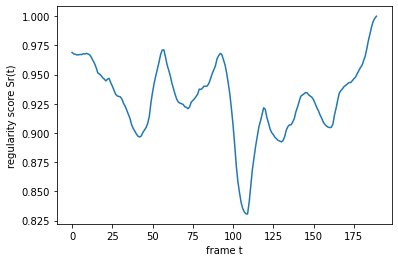

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test015
got model
got test


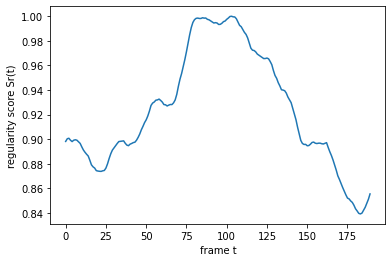

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test022
got model
got test


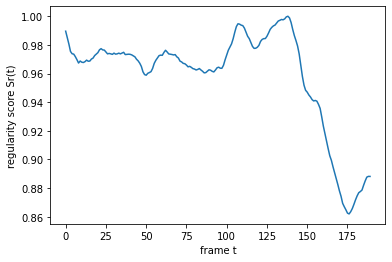

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test029
got model
got test


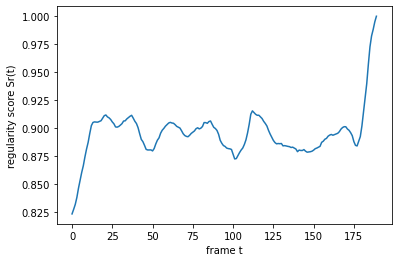

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test030
got model
got test


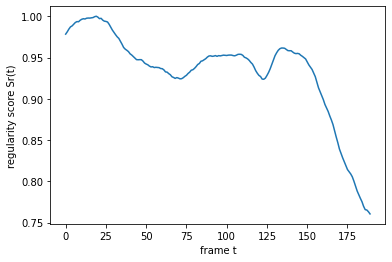

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test004
got model
got test


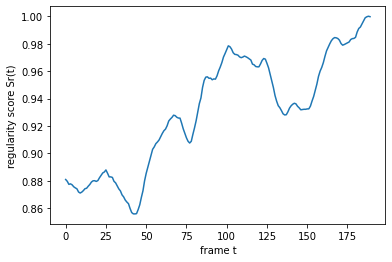

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test034
got model
got test


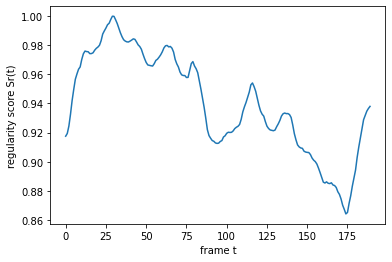

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test009
got model
got test


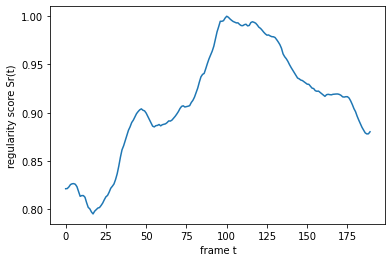

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test011
got model
got test


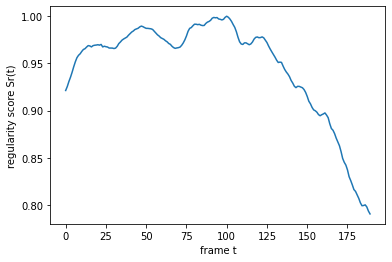

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test018
got model
got test


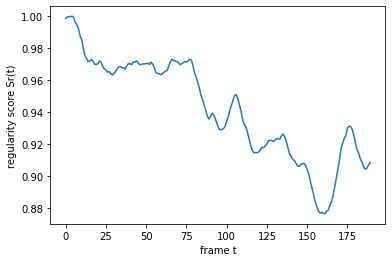

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test002
got model
got test


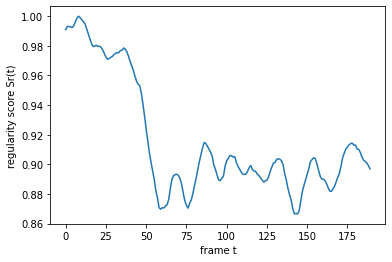

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test008
got model
got test


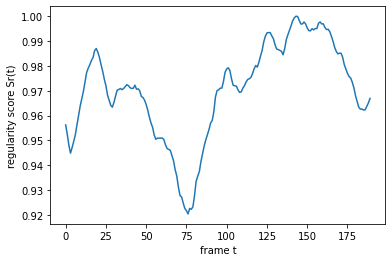

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test007
got model
got test


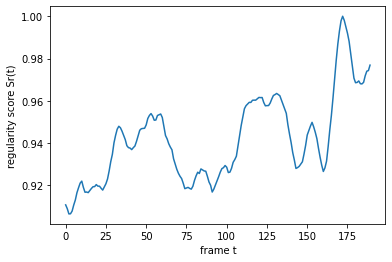

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test033
got model
got test


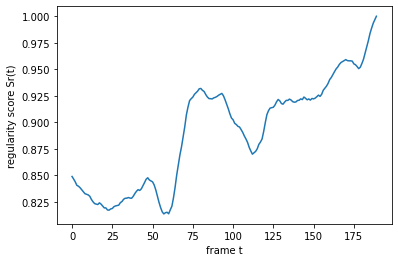

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test036
got model
got test


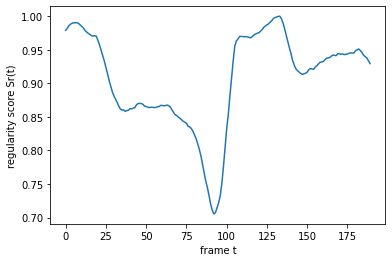

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test014
got model
got test


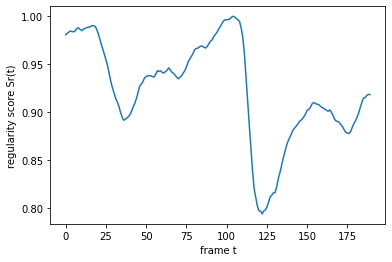

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test021
got model
got test


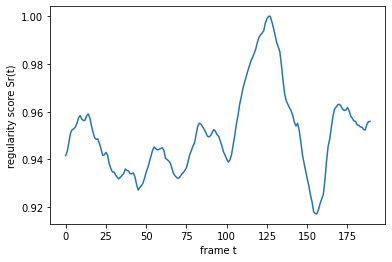

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test003
got model
got test


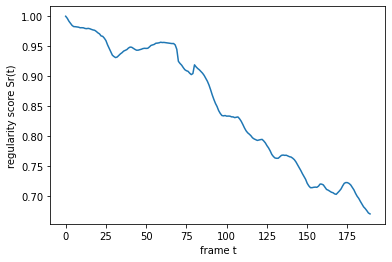

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test001
got model
got test


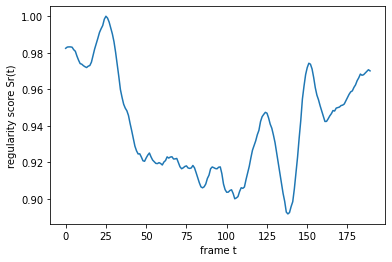

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test013
got model
got test


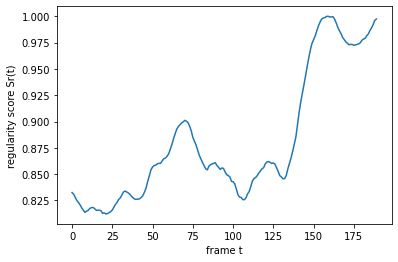

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test027
got model
got test


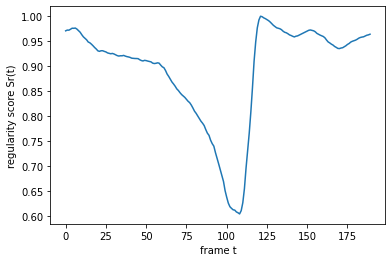

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test010
got model
got test


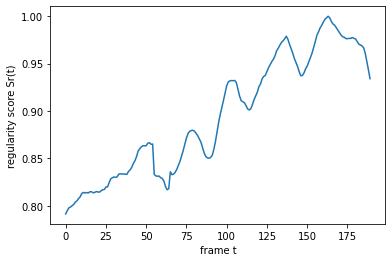

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test028
got model
got test


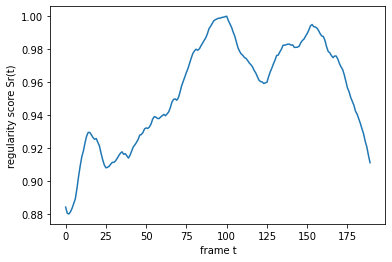

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test026
got model
got test


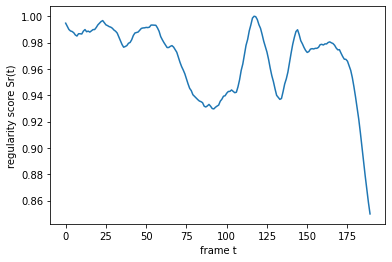

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test019
got model
got test


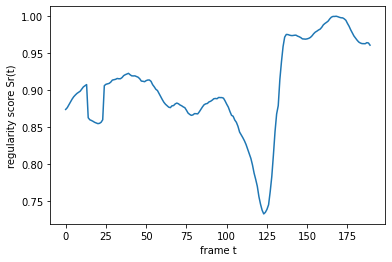

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test035
got model
got test


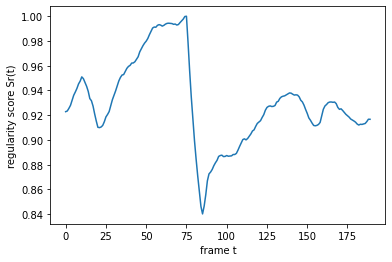

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test006
got model
got test


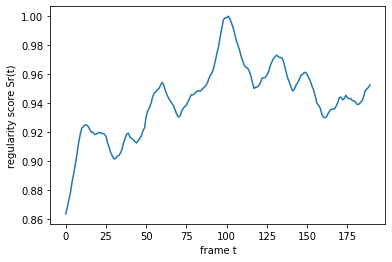

In [129]:
globalMetric = runTests(0.75)
precision,recall,F1, FPR = computeF1(globalMetric)

In [130]:
print(globalMetric.TP)
print(globalMetric.TN)
print(globalMetric.FP)
print(globalMetric.FN)

154
2762
0
3734


In [131]:
print("precision " + str(precision))
print("recall(TPR) " + str(recall))
print("F1 " + str(F1))
print("False positive rate " + str(FPR))

precision 0.9999999935064936
recall(TPR) 0.039609053487754876
F1 0.07619982770476702
False positive rate 0.0


UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test012
got model
got test


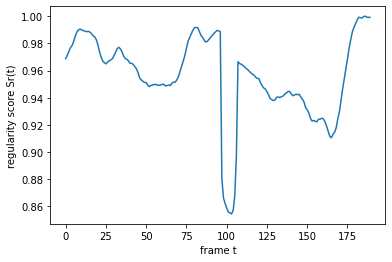

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test020
got model
got test


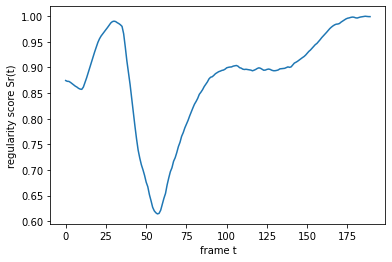

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test024
got model
got test


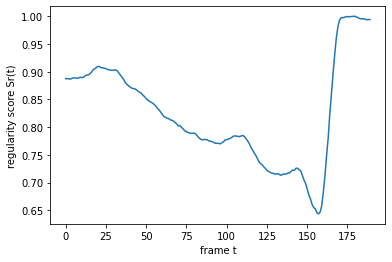

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test005
got model
got test


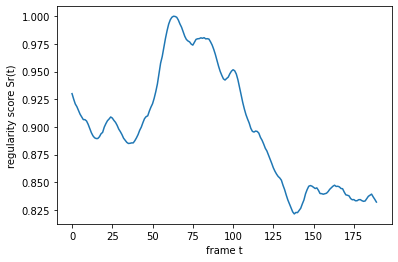

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test025
got model
got test


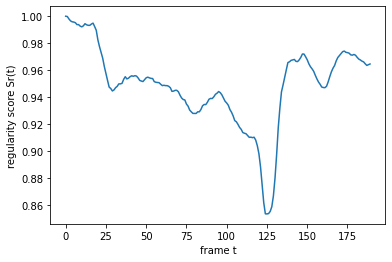

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test016
got model
got test


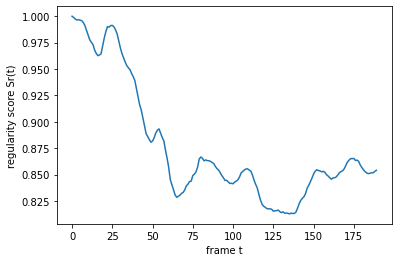

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test023
got model
got test


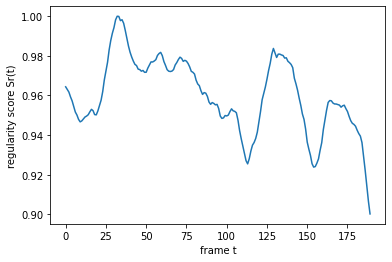

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test032
got model
got test


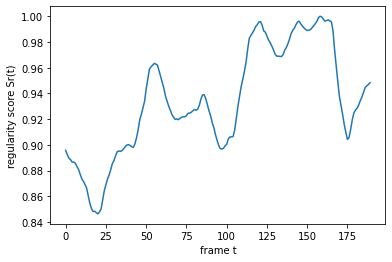

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test031
got model
got test


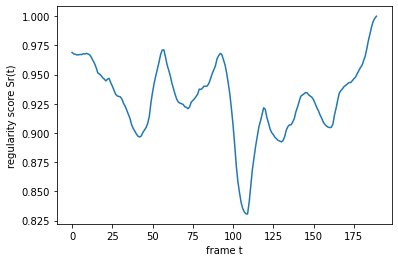

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test015
got model
got test


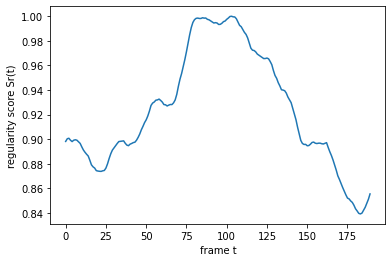

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test022
got model
got test


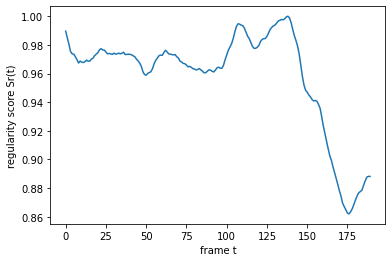

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test029
got model
got test


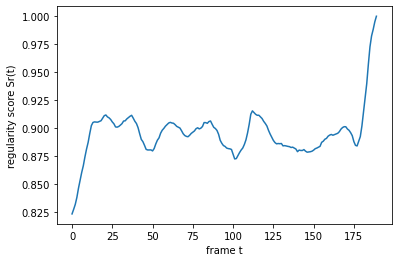

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test030
got model
got test


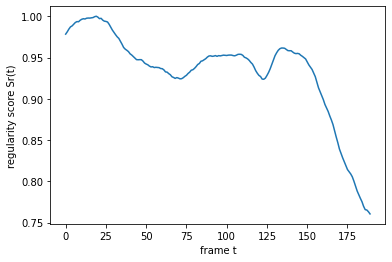

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test004
got model
got test


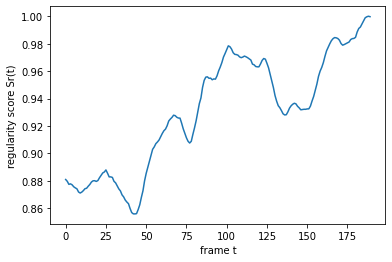

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test034
got model
got test


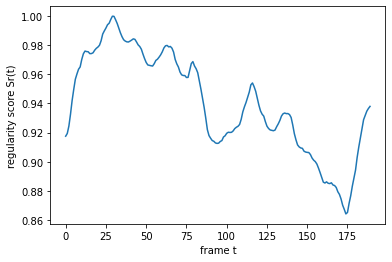

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test009
got model
got test


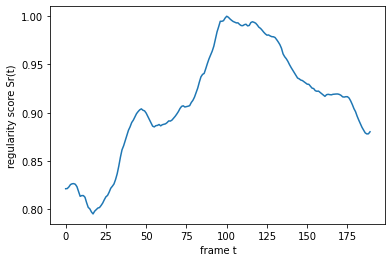

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test011
got model
got test


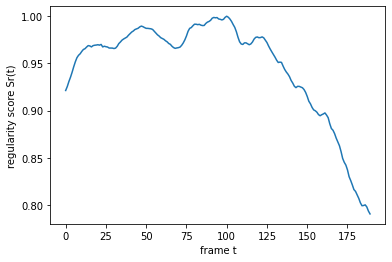

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test018
got model
got test


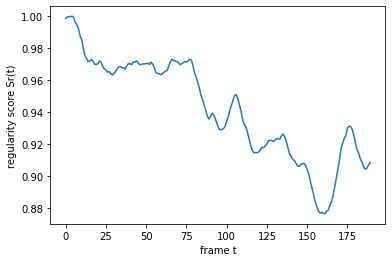

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test002
got model
got test


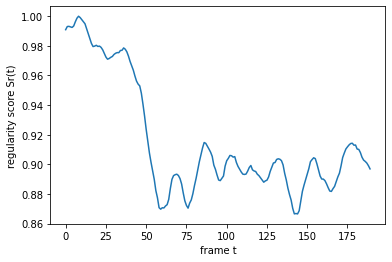

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test008
got model
got test


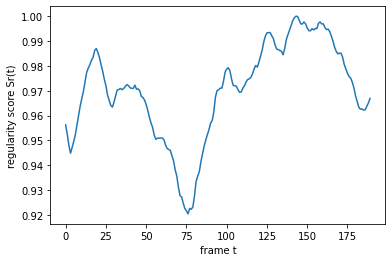

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test007
got model
got test


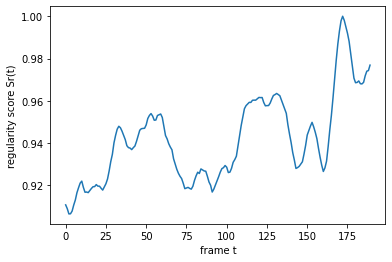

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test033
got model
got test


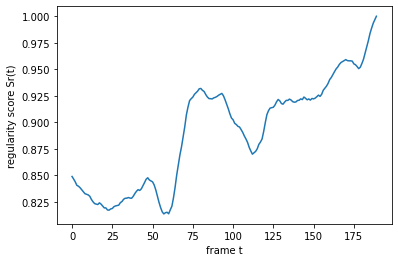

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test036
got model
got test


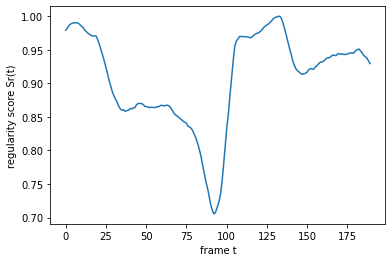

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test014
got model
got test


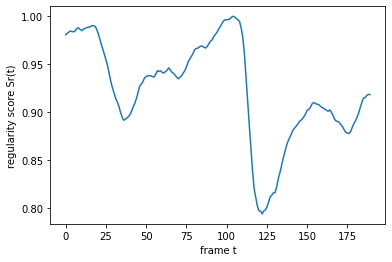

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test021
got model
got test


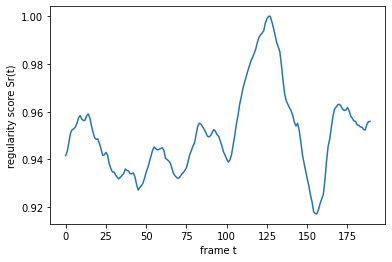

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test003
got model
got test


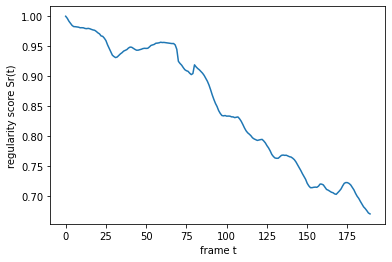

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test001
got model
got test


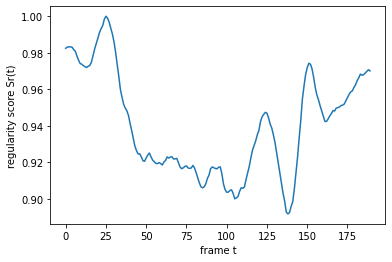

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test013
got model
got test


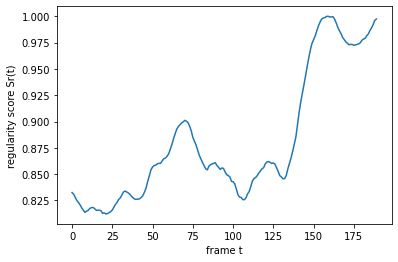

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test027
got model
got test


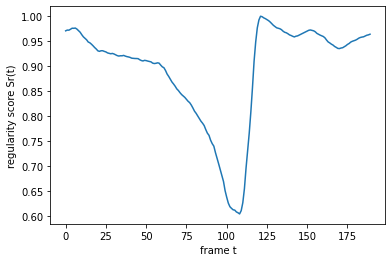

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test010
got model
got test


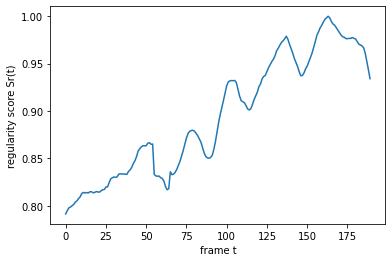

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test028
got model
got test


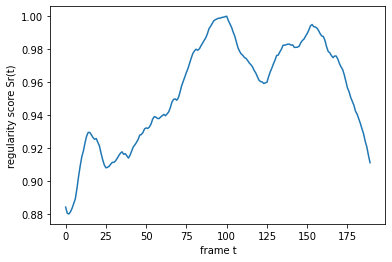

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test026
got model
got test


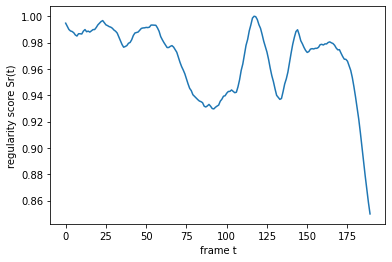

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test019
got model
got test


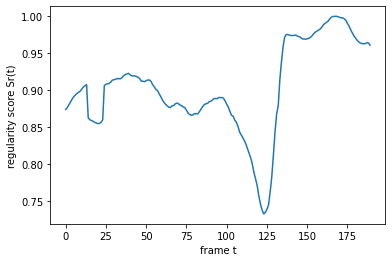

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test035
got model
got test


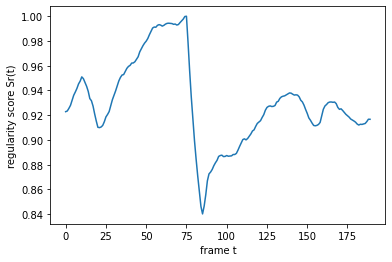

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test006
got model
got test


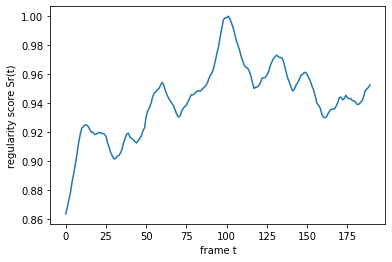

In [108]:
globalMetric = runTests(0.85)
precision,recall,F1, FPR = computeF1(globalMetric)

In [109]:
print("precision " + str(precision))
print("recall(TPR) " + str(recall))
print("F1 " + str(F1))
print("False positive rate " + str(FPR))

precision 0.9047029691773478
recall(TPR) 0.18801440324382346
F1 0.31132850541517754
False positive rate 0.027878349012353965


UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test012
got model
got test


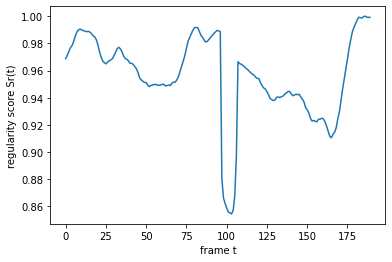

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test020
got model
got test


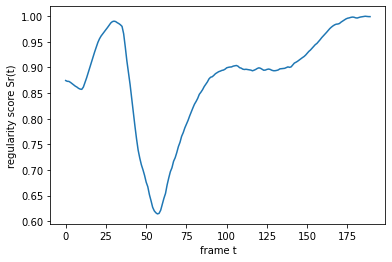

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test024
got model
got test


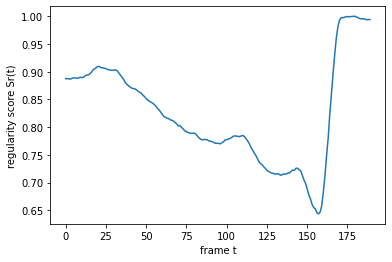

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test005
got model
got test


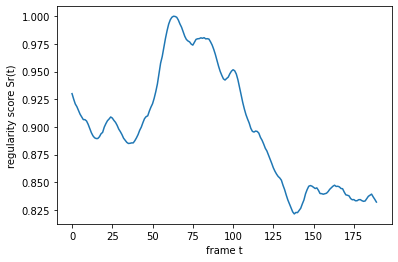

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test025
got model
got test


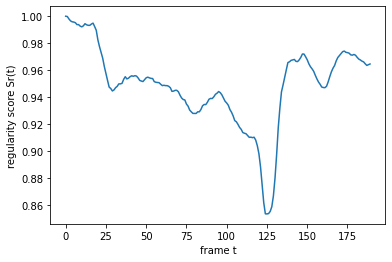

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test016
got model
got test


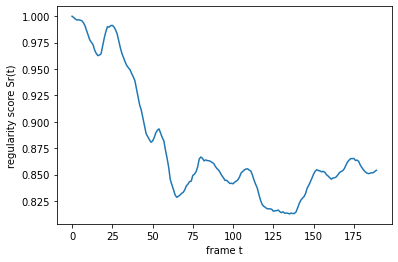

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test023
got model
got test


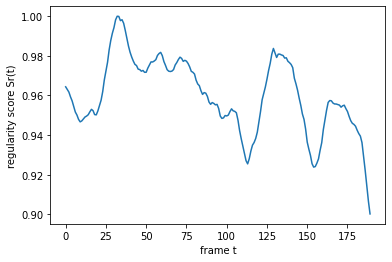

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test032
got model
got test


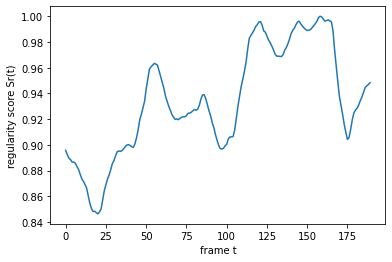

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test031
got model
got test


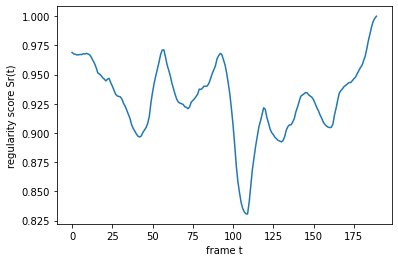

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test015
got model
got test


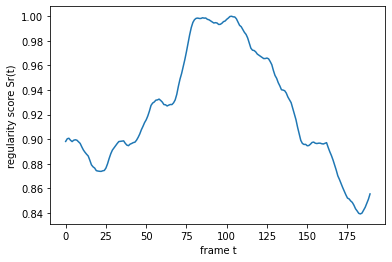

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test022
got model
got test


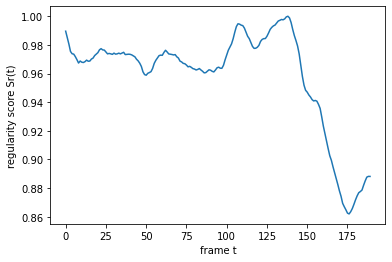

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test029
got model
got test


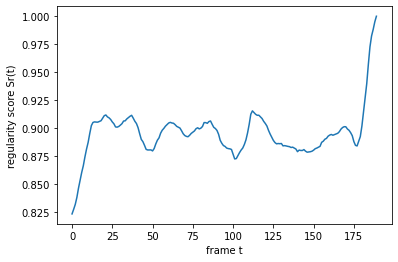

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test030
got model
got test


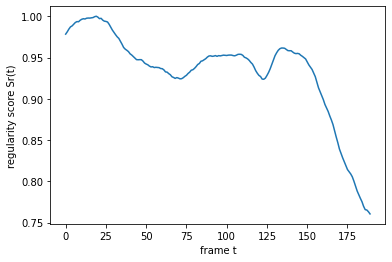

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test004
got model
got test


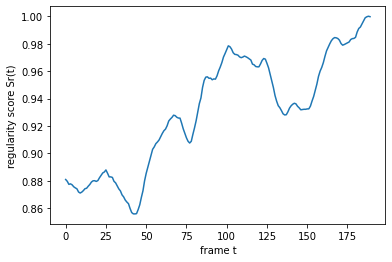

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test034
got model
got test


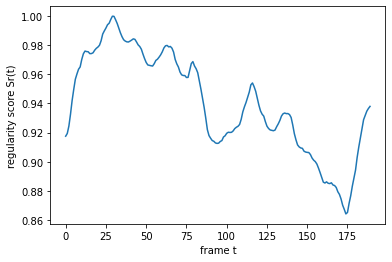

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test009
got model
got test


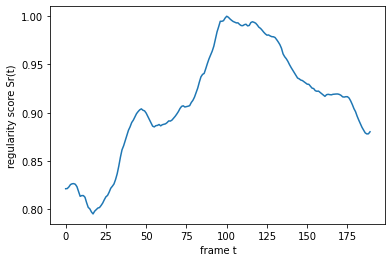

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test011
got model
got test


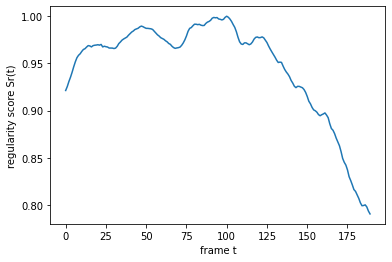

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test018
got model
got test


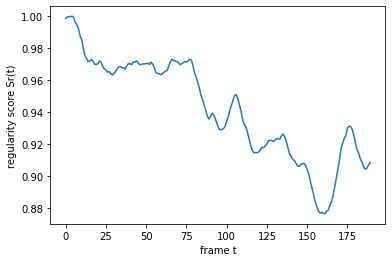

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test002
got model
got test


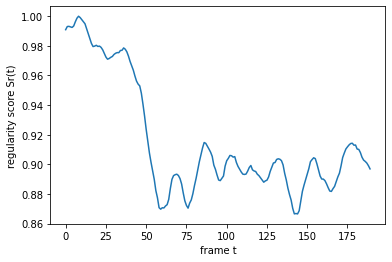

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test008
got model
got test


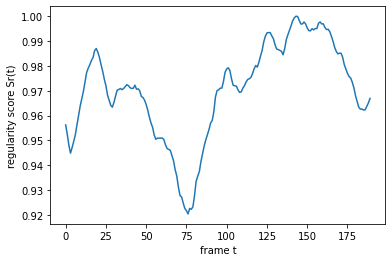

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test007
got model
got test


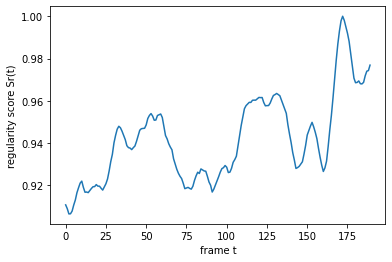

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test033
got model
got test


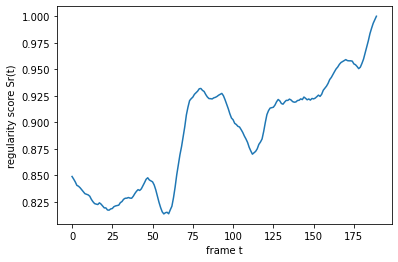

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test036
got model
got test


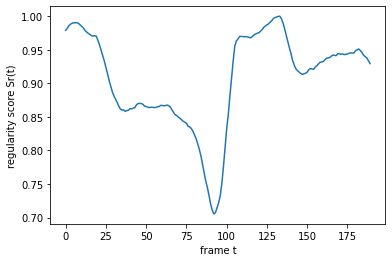

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test014
got model
got test


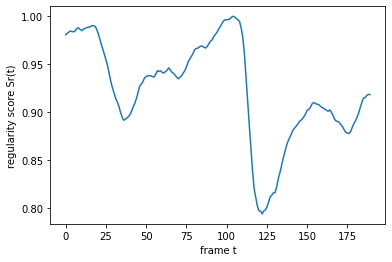

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test021
got model
got test


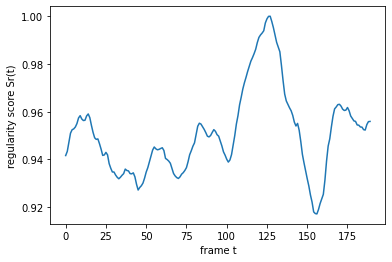

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test003
got model
got test


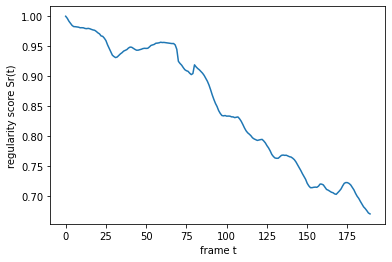

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test001
got model
got test


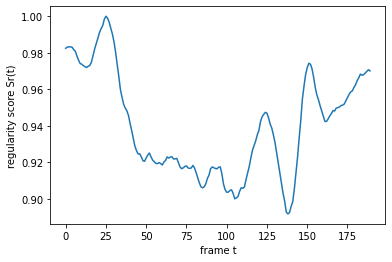

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test013
got model
got test


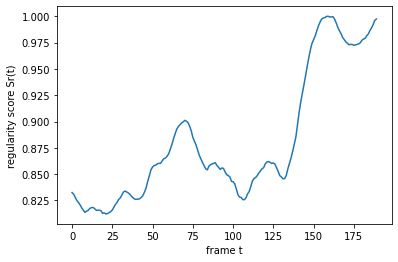

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test027
got model
got test


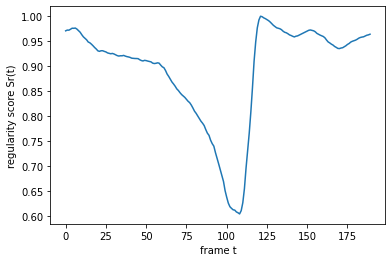

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test010
got model
got test


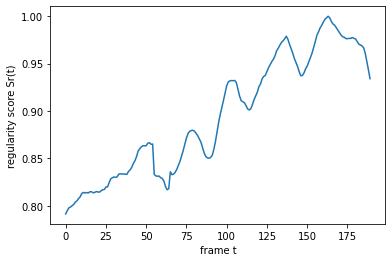

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test028
got model
got test


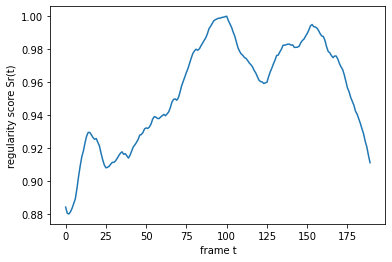

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test026
got model
got test


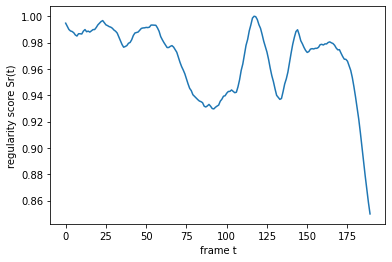

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test019
got model
got test


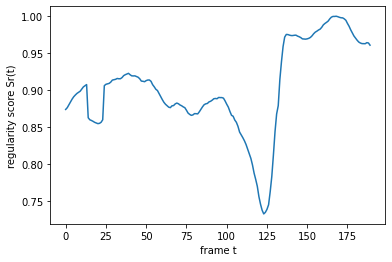

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test035
got model
got test


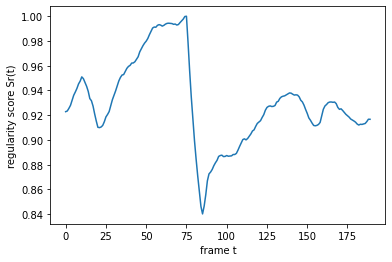

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test006
got model
got test


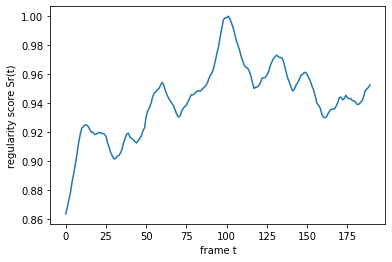

In [133]:
globalMetric = runTests(0.975)
precision,recall,F1, FPR = computeF1(globalMetric)

In [134]:
print(globalMetric.TP)
print(globalMetric.TN)
print(globalMetric.FP)
print(globalMetric.FN)

3517
827
1935
371


In [135]:
print("precision " + str(precision))
print("recall(TPR) " + str(recall))
print("F1 " + str(F1))
print("False positive rate " + str(FPR))

precision 0.6450843725889427
recall(TPR) 0.9045781890677526
F1 0.7531044389126385
False positive rate 0.7005792901156483


UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test012
got model
got test


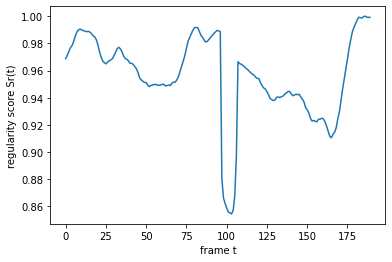

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test020
got model
got test


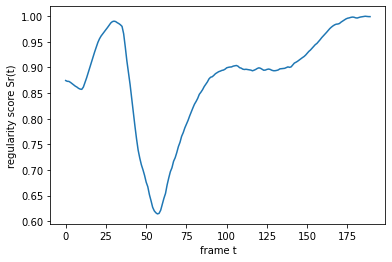

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test024
got model
got test


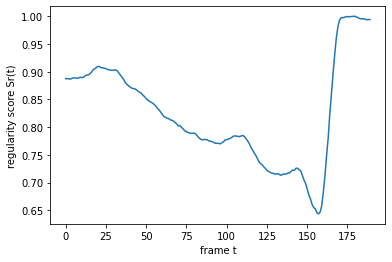

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test005
got model
got test


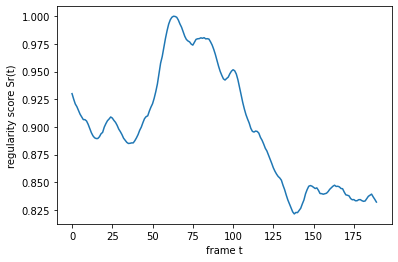

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test025
got model
got test


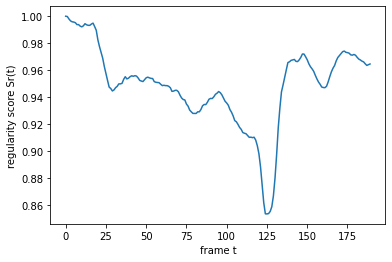

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test016
got model
got test


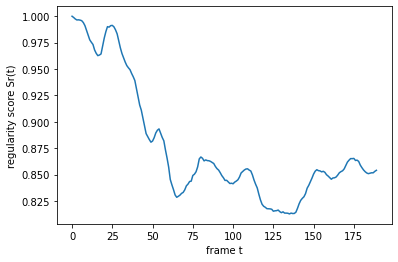

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test023
got model
got test


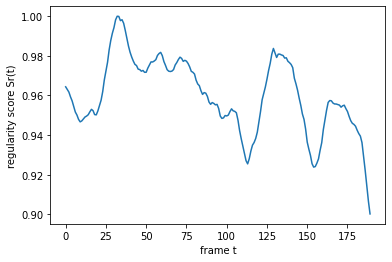

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test032
got model
got test


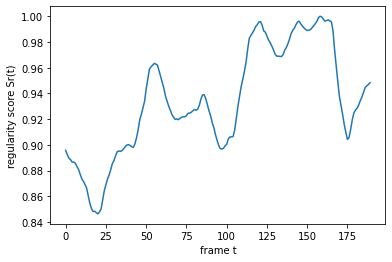

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test031
got model
got test


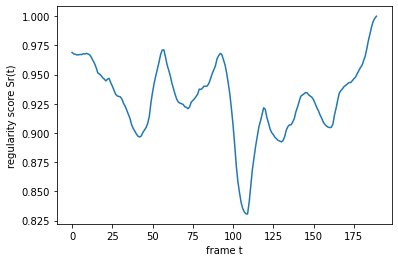

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test015
got model
got test


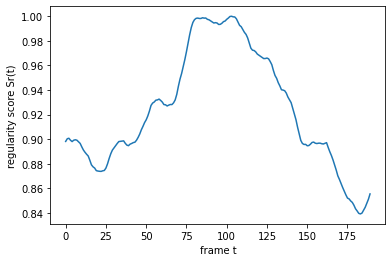

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test022
got model
got test


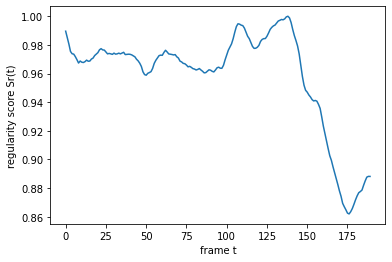

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test029
got model
got test


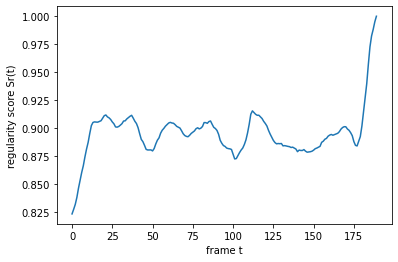

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test030
got model
got test


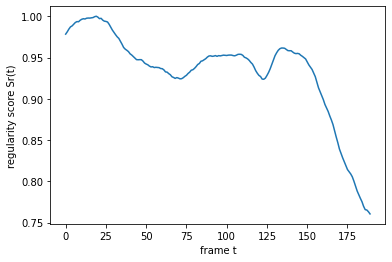

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test004
got model
got test


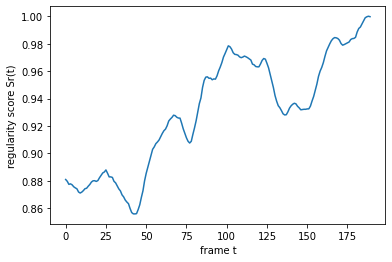

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test034
got model
got test


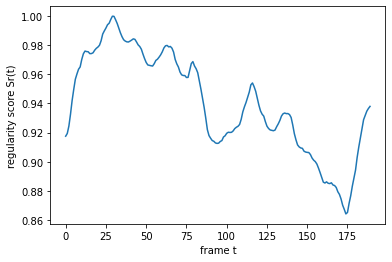

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test009
got model
got test


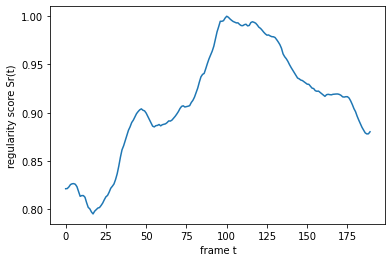

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test011
got model
got test


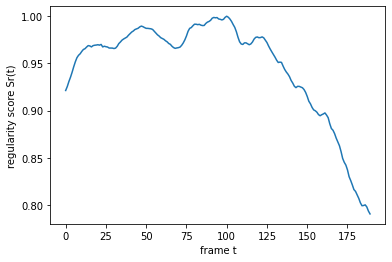

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test018
got model
got test


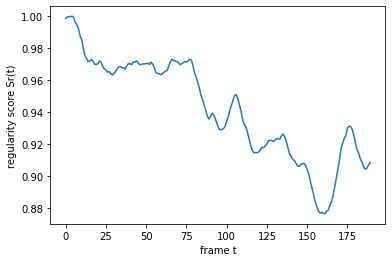

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test002
got model
got test


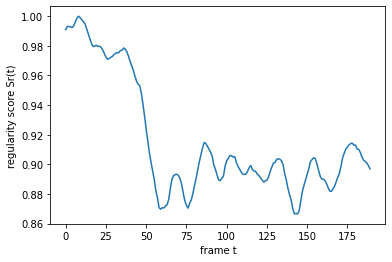

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test008
got model
got test


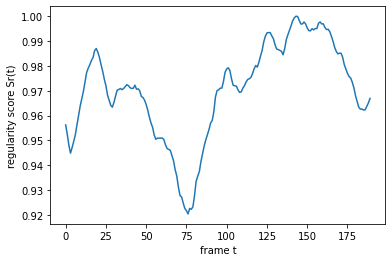

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test007
got model
got test


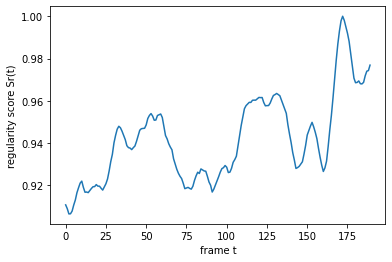

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test033
got model
got test


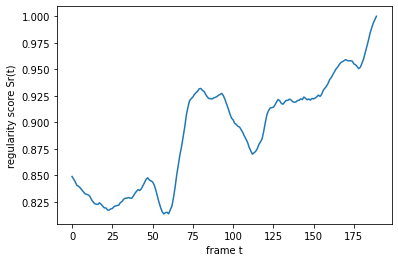

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test036
got model
got test


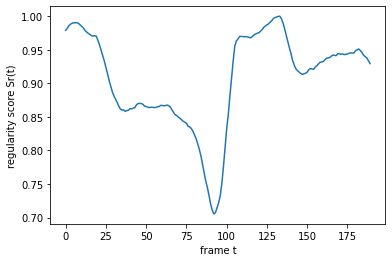

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test014
got model
got test


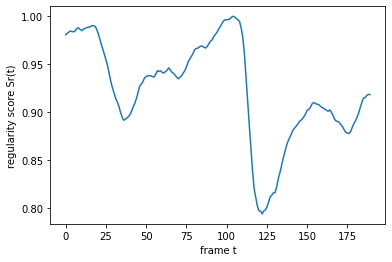

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test021
got model
got test


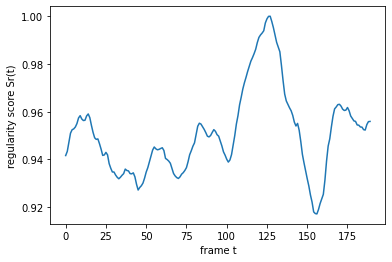

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test003
got model
got test


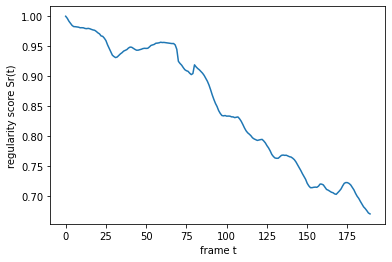

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test001
got model
got test


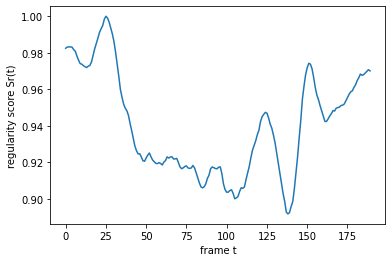

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test013
got model
got test


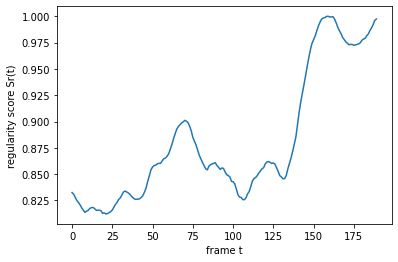

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test027
got model
got test


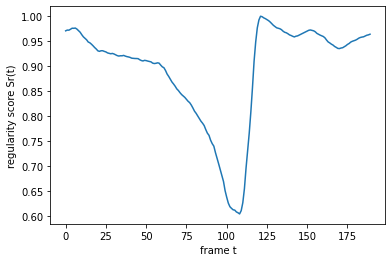

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test010
got model
got test


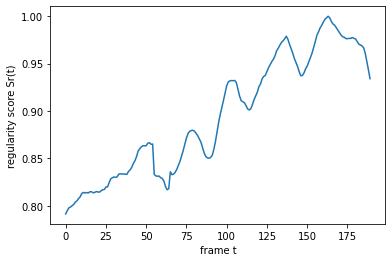

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test028
got model
got test


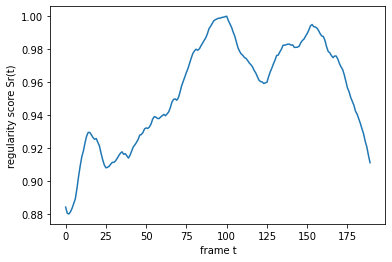

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test026
got model
got test


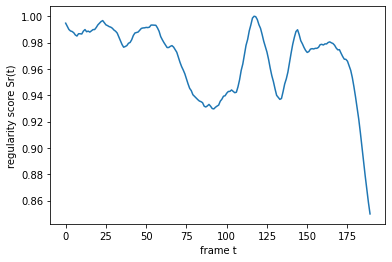

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test019
got model
got test


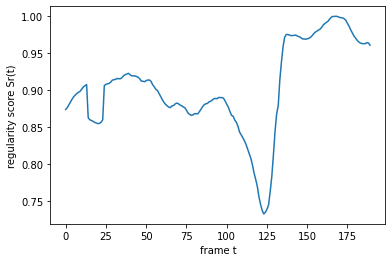

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test035
got model
got test


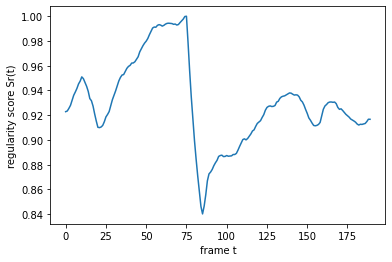

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test006
got model
got test


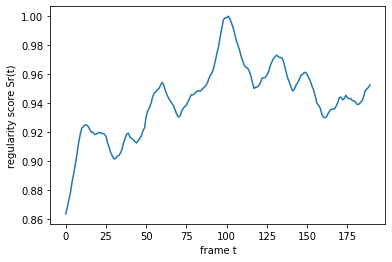

In [136]:
globalMetric = runTests(0.99)
precision,recall,F1, FPR = computeF1(globalMetric)

In [139]:
print(globalMetric.TP)
print(globalMetric.TN)
print(globalMetric.FP)
print(globalMetric.FN)

3768
400
2362
120


In [140]:
print("precision " + str(precision))
print("recall(TPR) " + str(recall))
print("F1 " + str(F1))
print("False positive rate " + str(FPR))

precision 0.6146818922325151
recall(TPR) 0.9691358022198725
F1 0.7522454821696082
False positive rate 0.8551774073659749


UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test012
got model
got test


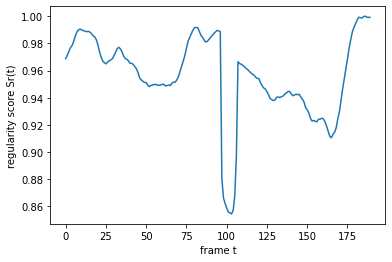

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test020
got model
got test


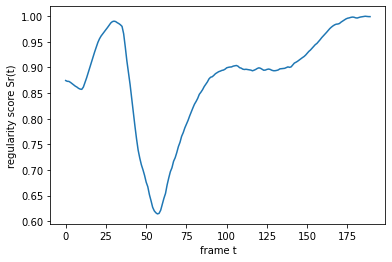

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test024
got model
got test


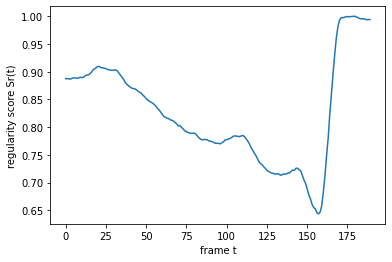

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test005
got model
got test


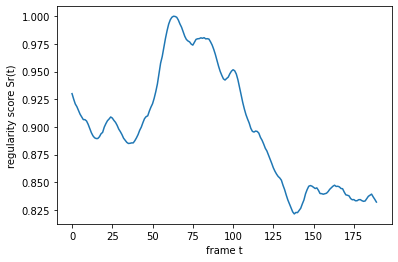

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test025
got model
got test


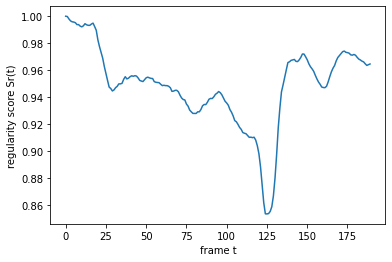

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test016
got model
got test


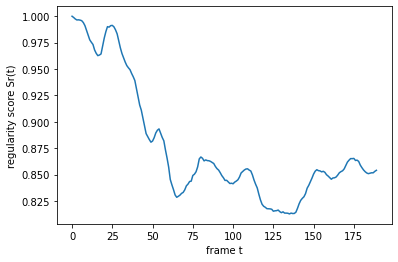

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test023
got model
got test


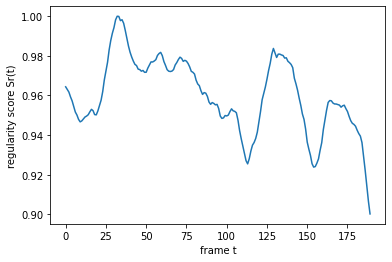

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test032
got model
got test


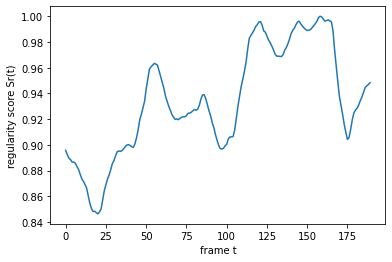

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test031
got model
got test


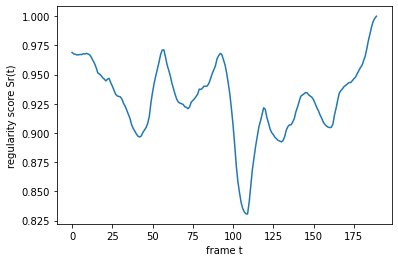

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test015
got model
got test


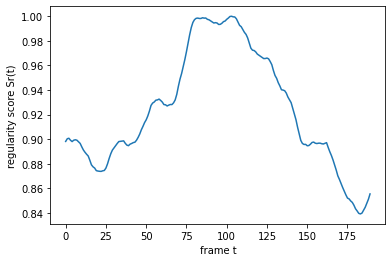

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test022
got model
got test


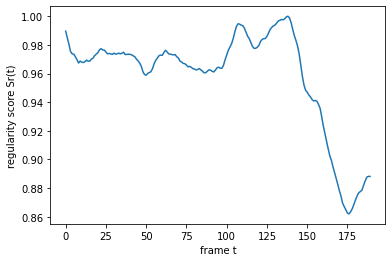

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test029
got model
got test


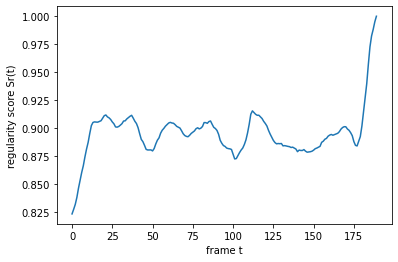

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test030
got model
got test


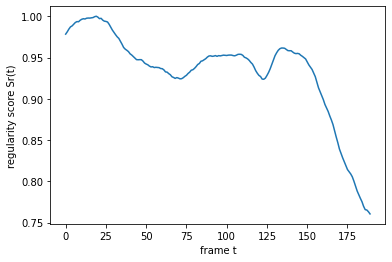

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test004
got model
got test


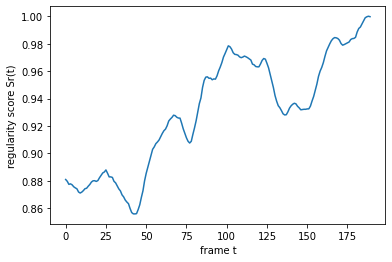

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test034
got model
got test


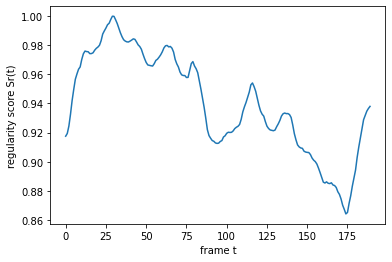

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test009
got model
got test


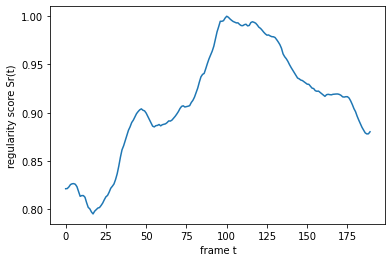

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test011
got model
got test


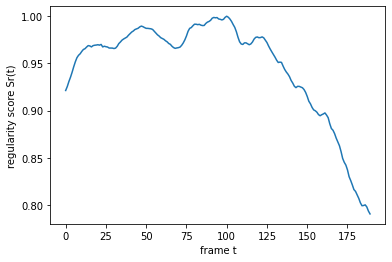

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test018
got model
got test


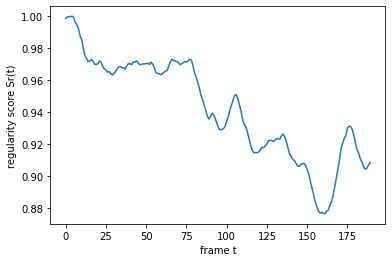

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test002
got model
got test


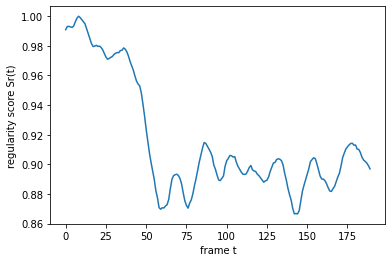

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test008
got model
got test


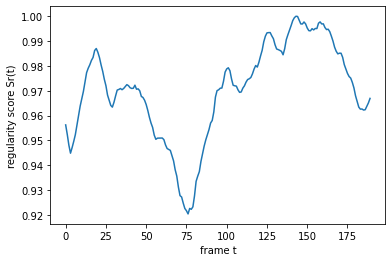

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test007
got model
got test


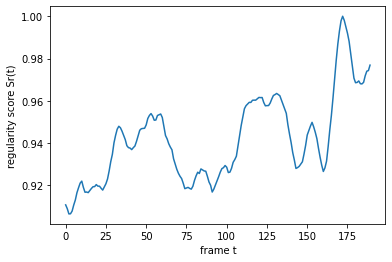

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test033
got model
got test


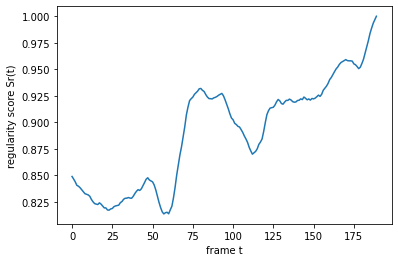

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test036
got model
got test


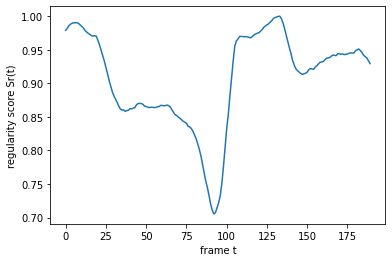

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test014
got model
got test


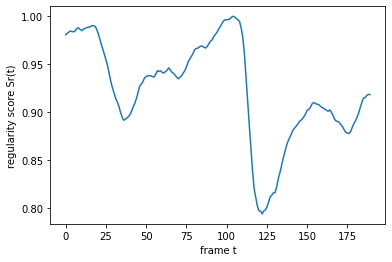

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test021
got model
got test


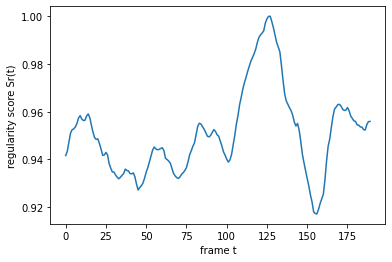

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test003
got model
got test


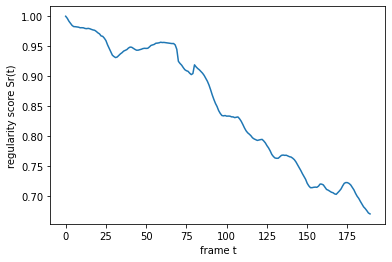

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test001
got model
got test


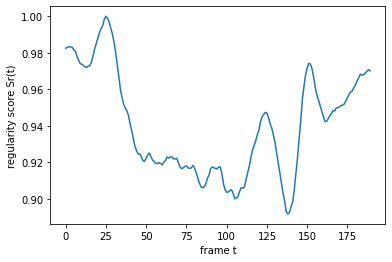

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test013
got model
got test


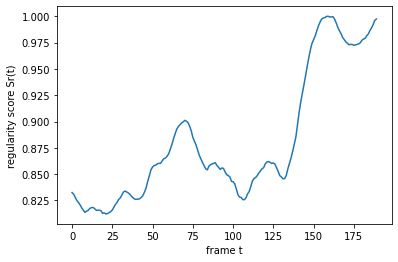

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test027
got model
got test


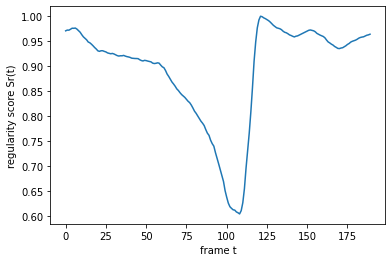

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test010
got model
got test


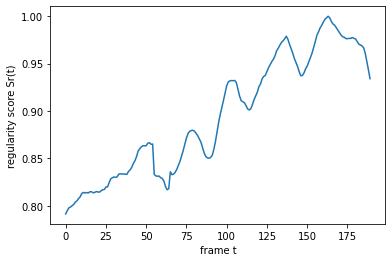

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test028
got model
got test


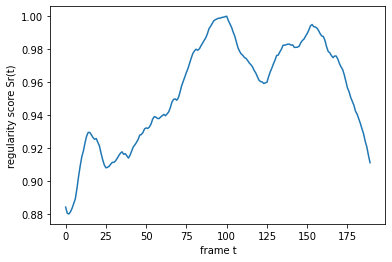

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test026
got model
got test


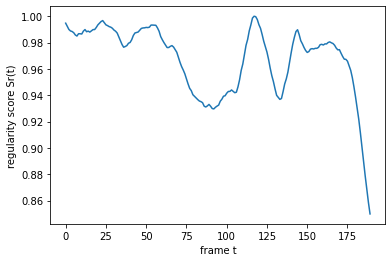

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test019
got model
got test


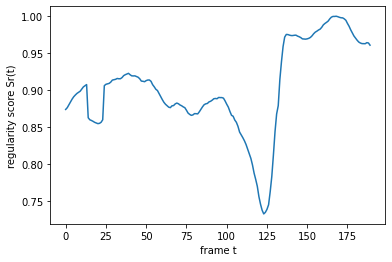

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test035
got model
got test


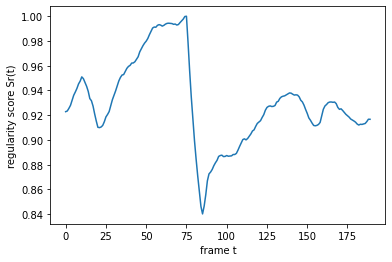

UCSD_Anomaly_Dataset.v1p2/UCSDped1//Test/Test006
got model
got test


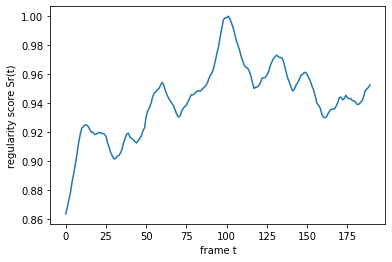

In [141]:
globalMetric = runTests(0.99)
precision,recall,F1, FPR = computeF1(globalMetric)

In [142]:
print(globalMetric.TP)
print(globalMetric.TN)
print(globalMetric.FP)
print(globalMetric.FN)

3768
400
2362
120


In [143]:
print("precision " + str(precision))
print("recall(TPR) " + str(recall))
print("F1 " + str(F1))
print("False positive rate " + str(FPR))

precision 0.6146818922325151
recall(TPR) 0.9691358022198725
F1 0.7522454821696082
False positive rate 0.8551774073659749


In [7]:
globalMetric = runTests(0.70)
precision,recall,F1, FPR = computeF1(globalMetric)

NameError: name 'runTests' is not defined

In [76]:
#LSTM AutoEncoder
# precision and recall for 0.65, 0.70 , 0.75, 0.80,0.85,0.90,0.95 regularity score

recall_scores = [0.0059, 0.014, 0.039, .072, .188, .372, 0.728]
precision_scores = [0.99, 0.99, 0.99, 0.97, 0.904, 0.748, 0.691]
#Variational autoEncoder

v_recall_scores =[0.025, 0.076, 0.184, 0.318, 0.489, 0.699, 0.903]
v_precision_scores =[0.99, 0.97,0.877,0.784, 0.733, 0.681, 0.641 ]

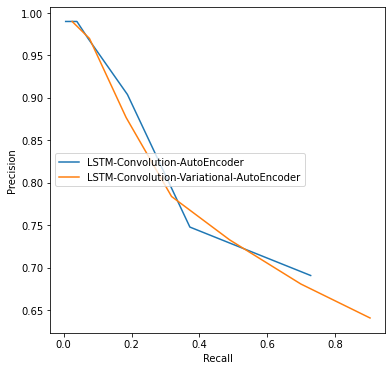

In [77]:
# Plot precision-recall curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall_scores, precision_scores, label='LSTM-Convolution-AutoEncoder')
ax.plot(v_recall_scores, v_precision_scores, label='LSTM-Convolution-Variational-AutoEncoder')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left');
ax

In [132]:
#LSTM AutoEncoder
# precision and recall for 0.65, 0.70 , 0.75, 0.80,0.85,0.90,0.95 regularity score

TPR = [0.0059, 0.014, 0.039, .072, .188, .372, 0.728]
FPR = [0.0, 0.0, 0.0, 0.002, 0.027, 0.176, 0.458]
#Variational autoEncoder

v_TPR =[0.025, 0.076, 0.184, 0.318, 0.489, 0.699, 0.903]
v_FPR =[0.0, 0.003,0.036,0.122, 0.25, 0.459, 0.709 ]

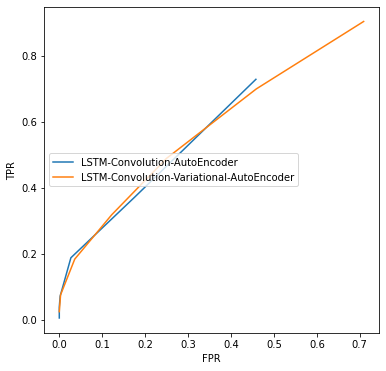

In [135]:
# Plot precision-recall curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,6))
ax.plot( FPR, TPR, label='LSTM-Convolution-AutoEncoder')
ax.plot( v_FPR,v_TPR, label='LSTM-Convolution-Variational-AutoEncoder')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend(loc='center left');
ax

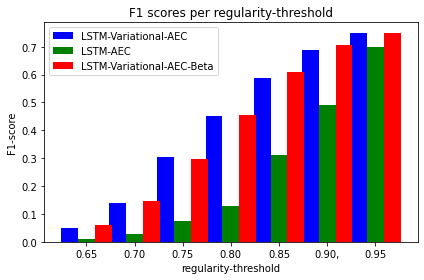

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
marks_john = [.049, 0.14, 0.304, 0.452,0.587,0.690,0.75]
marks_sam = [0.011, 0.027, 0.076, 0.13,0.311,0.49, 0.70]
marks_beta = [0.06, 0.148, 0.298, 0.455 ,0.609 ,0.707, 0.748]
# create plot
fig, ax = plt.subplots()
bar_width = 0.35
X = np.arange(7)

p1 = plt.bar(X, marks_john, bar_width, color='b',
label='LSTM-Variational-AEC')

# The bar of second plot starts where the first bar ends
p2 = plt.bar(X + bar_width , marks_sam, bar_width,
color='g',
label='LSTM-AEC')

p3 = plt.bar(X + bar_width + bar_width, marks_beta, bar_width,
color='r',
label='LSTM-Variational-AEC-Beta')

plt.xlabel('regularity-threshold')
plt.ylabel('F1-score')
plt.title('F1 scores per regularity-threshold')
plt.xticks(X + (bar_width) , ("0.65", "0.70", 
"0.75", "0.80", "0.85", "0.90,", "0.95"))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('total frames', 'anomaly-frames', 'regular-frames')
y_pos = np.arange(len(objects))
performance = [6650, 3888, 2762]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frame Count')
plt.title('Total Frames and Anomaly Frames in USCD PED1 test dataset')

plt.show()

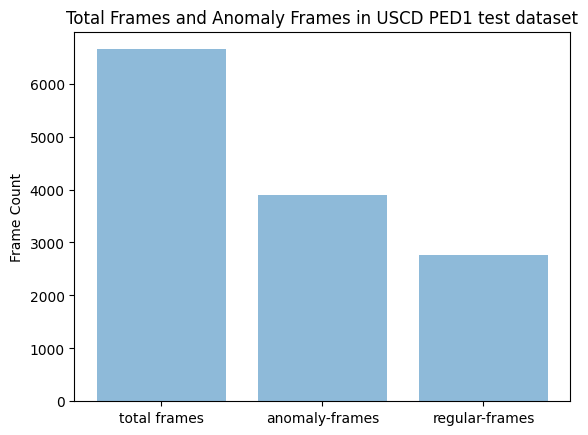

In [139]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('total frames', 'anomaly-frames', 'regular-frames')
y_pos = np.arange(len(objects))
performance = [6650, 3888, 2762]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frame Count')
plt.title('Total Frames and Anomaly Frames in USCD PED1 test dataset')

plt.show()

In [113]:
from PIL import Image as im
import matplotlib.pyplot as plt
def plotImages(orig_image, reconst_image, orig_image2, reconst_image2):
    # create figure
    fig = plt.figure(figsize=(10, 7))
    # setting values to rows and column variables
    rows = 2
    columns = 2
  
    
  
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)
  
    # showing image
    plt.imshow(orig_image)
    plt.axis('off')
    plt.title("original")
  
    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)
  
    # showing image
    plt.imshow(reconst_image)
    plt.axis('off')
    plt.title("reconstruct")
  
    # Adds a subplot at the 3rd position
    fig.add_subplot(rows, columns, 3)
  
    # showing image
    plt.imshow(orig_image2)
    plt.axis('off')
    plt.title("original")
  
    # Adds a subplot at the 4th position
    fig.add_subplot(rows, columns, 4)
  
    # showing image
    plt.imshow(reconst_image2)
    plt.axis('off')
    plt.title("reconstruct")

In [114]:
def extractImage(clip_images, i, j):
    
     clip_image = clip_images[i, j,:,:,:]       
     clip_image = clip_image.squeeze()
     clip_image = clip_image.reshape(clip_image.shape[0], clip_image.shape[1], 1)
     return  clip_image  

In [115]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def visualize(model, test_path ): 
    """ Visualizes the original images and the reconstructed ones for `n_samples` examples 
    on the test set `X_test`."""
      
    print("got model")
    test = get_single_test(test_path)
    print("got test")
    sz = test.shape[0] - 10
    original_images = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        original_images[i] = clip

    reconstructed_images = model.predict(original_images,batch_size=4)
    print("shape of reconstructed images " + str(original_images.shape))  
    print("shape of reconstructed images " + str(reconstructed_images.shape))
    # Displaying the plot 
     
    
    for index in range(0, 4, 2):
        orig_image = extractImage(original_images,  0, 0+index)
        orig_image2 = extractImage(original_images,  0, 1+index)
        reconst_image = extractImage(reconstructed_images,  0, 0+index)
        reconst_image2 = extractImage(reconstructed_images,  0, 1+index)
        
       
        #imgplot2 = plt.imshow(reconst_image)
        plotImages(orig_image, reconst_image,orig_image2, reconst_image2)
        

In [117]:
# Plots `n_samples` images. Top row is the original images and the lower row is the reconstructed ones.
n_samples = 10
#fig= visualize(loaded_model,BASE + "/Train/Train033")